<a href="https://colab.research.google.com/github/lashik/Sepm_practicals_114/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

In [ ]:
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
from pytube import YouTube

# 📌 Paste your YouTube URL
video_url = "https://www.youtube.com/watch?v=k50eHjB5xF8"

# Choose highest resolution progressive stream (includes video + audio)
yt = YouTube(video_url)
stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()

# Download to Colab environment
stream.download(filename="input_video.mp4")

print("✅ Video downloaded as input_video.mp4")


HTTPError: HTTP Error 400: Bad Request

In [ ]:
from shapely.geometry import Point, Polygon
from ultralytics import YOLO
import cv2
import numpy as np
from collections import defaultdict

# Load all models
player_model = YOLO("/content/drive/MyDrive/Zion Tech /yolov8x.pt")
ball_model = YOLO("/content/drive/MyDrive/Zion Tech /best.pt")
court_model = YOLO("/content/drive/MyDrive/Zion Tech /best (1).pt")  # <--- Replace with your court model path


cap = cv2.VideoCapture("/content/drive/MyDrive/Zion Tech /20250716113923189_FW9026774_hcDownloadP_Camera 02_2_video.mov")
if not cap.isOpened():
    print("error Could not open video file: ")

fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_idx = 0

court_polygon = None
player_positions = defaultdict(list)
ball_positions_list = []
out_of_bounds_events = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    timestamp = frame_idx / fps

    # 1. Court Detection (first frame only or when not detected)
    if court_polygon is None and frame_idx < 5:
        try:
            court_results = court_model.predict(frame, verbose=False)[0]
            for box in court_results.boxes.data:
                x1, y1, x2, y2, conf, cls = box.cpu().numpy()
                if int(cls) == 0:  # Assuming class 0 is 'court'
                    court_polygon = Polygon([
                        (x1, y1), (x2, y1), (x2, y2), (x1, y2)
                    ])
                    break  # Use the first court found
        except Exception as e:
            print(f"[Warning] Failed to detect court on frame {frame_idx}: {e}")

    # 2. Player Detection
    try:
        player_results = player_model.predict(frame, verbose=False)[0]
        for box in player_results.boxes.data:
            x1, y1, x2, y2, conf, cls = box.cpu().numpy()
            if int(cls) == 0:
                cx = int((x1 + x2) / 2)
                cy = int((y1 + y2) / 2)
                player_positions[frame_idx].append({"x": cx, "y": cy, "conf": float(conf)})
    except:
        pass
    label = "IN"
    color = (0, 255, 0)
    # 3. Ball Detection + Boundary Check
    try:
        ball_results = ball_model.predict(frame, verbose=False)[0]
        for box in ball_results.boxes.data:
            x1, y1, x2, y2, conf, cls = box.cpu().numpy()
            if int(cls) == 0:
                cx = int((x1 + x2) / 2)
                cy = int((y1 + y2) / 2)
                ball_positions_list.append({"frame": frame_idx, "x": cx, "y": cy, "conf": float(conf)})

                if court_polygon and not court_polygon.contains(Point(cx, cy)):
                    label = "OUT"
                    color = (0, 0, 255)  # Red

                    out_of_bounds_events.append({
                        "frame": frame_idx,
                        "time": round(timestamp, 2),
                        "x": cx,
                        "y": cy,
                        "conf": float(conf)
                    })
                    print(f"🚫 Ball OUT detected! Frame {frame_idx}, Time {round(timestamp, 2)}s, X:{cx}, Y:{cy}, Conf:{conf:.2f}")

                # --- Draw bounding box and label ---
                # Draw ball bounding box
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

                # Overlay label with timestamp
                text = f"{label} @ {round(timestamp, 2)}s"
                cv2.putText(frame, text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Save frame to disk (optional)
                cv2.imwrite(f"/content/frame_{frame_idx}_{label}.jpg", frame)
                break  # Only one ball per frame
    except:
        pass

cap.release()

# Prepare flat list of player points
all_player_points = []
for frame_id, pts in player_positions.items():
    all_player_points.extend(pts)

unique_ball_frames = set(p['frame'] for p in ball_positions_list if p['conf'] > 0.5)
print(out_of_bounds_events)



🚫 Ball OUT detected! Frame 18, Time 0.9s, X:983, Y:1317, Conf:0.30
🚫 Ball OUT detected! Frame 38, Time 1.9s, X:1059, Y:1370, Conf:0.30
🚫 Ball OUT detected! Frame 68, Time 3.4s, X:145, Y:1421, Conf:0.47
🚫 Ball OUT detected! Frame 151, Time 7.55s, X:646, Y:1331, Conf:0.57
🚫 Ball OUT detected! Frame 165, Time 8.25s, X:519, Y:1327, Conf:0.62
🚫 Ball OUT detected! Frame 166, Time 8.3s, X:524, Y:1291, Conf:0.58
🚫 Ball OUT detected! Frame 182, Time 9.1s, X:1065, Y:131, Conf:0.27
🚫 Ball OUT detected! Frame 183, Time 9.15s, X:1065, Y:131, Conf:0.30
🚫 Ball OUT detected! Frame 277, Time 13.85s, X:918, Y:167, Conf:0.64
🚫 Ball OUT detected! Frame 278, Time 13.9s, X:972, Y:130, Conf:0.62
🚫 Ball OUT detected! Frame 289, Time 14.45s, X:1250, Y:180, Conf:0.46
🚫 Ball OUT detected! Frame 321, Time 16.04s, X:876, Y:149, Conf:0.59
🚫 Ball OUT detected! Frame 322, Time 16.09s, X:835, Y:211, Conf:0.45
🚫 Ball OUT detected! Frame 392, Time 19.59s, X:1013, Y:90, Conf:0.48
🚫 Ball OUT detected! Frame 393, Time 19.6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
video_path = "/content/20250716113923189_FW9026774_hcDownloadP_Camera 02_2_video.mov"  # Update if needed

results = analyze_pickleball_video(video_path)

# Print as JSON-formatted result
import pprint


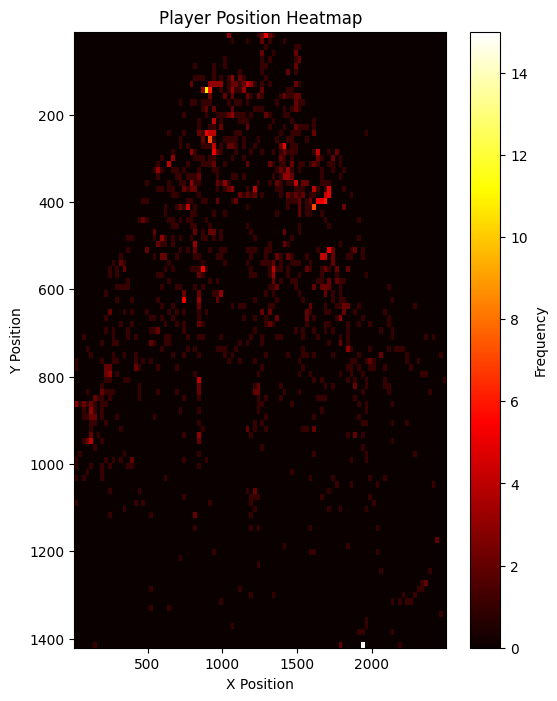

In [ ]:
import matplotlib.pyplot as plt

# Plot player heatmap
xs = [p['x'] for p in results["ball_trail"]]
ys = [p['y'] for p in results["ball_trail"]]

plt.figure(figsize=(6, 8))
plt.hist2d(xs, ys, bins=100, cmap='hot')
plt.title("Player Position Heatmap")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.colorbar(label='Frequency')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

# ✅ Load your trained model (update path if needed)
model = YOLO("yolov8n.pt")  # Replace with your model path

# 🔗 Your ngrok stream URL
stream_url = 'http://abc123.ngrok.io/video_feed'  # Use HTTP not HTTPS

cap = cv2.VideoCapture(stream_url)

if not cap.isOpened():
    print("❌ Could not open video stream. Check ngrok and ffmpeg.")
else:
    print("✅ Stream connected.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("⚠️ Frame not received")
        break

    # Run inference
    results = model.predict(frame, conf=0.3, verbose=False)

    # Process detections
    for box in results[0].boxes:
        cls = int(box.cls[0])
        label = results[0].names[cls]
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

        # 🔍 Decide in/out using your logic
        if label.lower() == "ball":
            if cx < frame.shape[1] // 2:  # Left half of frame
                verdict = "IN"
            else:
                verdict = "OUT"
            cv2.putText(frame, f"{label.upper()} - {verdict}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0) if verdict=="IN" else (0,0,255), 2)
        elif label.lower() == "court":
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)
            cv2.putText(frame, "COURT", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 255), 1)

    # Display the frame
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(rgb))
    clear_output(wait=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 116MB/s]


❌ Could not open video stream. Check ngrok and ffmpeg.
⚠️ Frame not received


In [ ]:
!gdown 1LKalbrTNN3jxX6r6O2Om0gNiZIrxDud3

Downloading...
From (original): https://drive.google.com/uc?id=1LKalbrTNN3jxX6r6O2Om0gNiZIrxDud3
From (redirected): https://drive.google.com/uc?id=1LKalbrTNN3jxX6r6O2Om0gNiZIrxDud3&confirm=t&uuid=529d6394-7bcd-4156-b6a1-64363fe2fad4
To: /content/record.mov
100% 1.42G/1.42G [00:10<00:00, 135MB/s]


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
!pip install --force-reinstall sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 43.3 MB/s eta 0:00:00
  Attempting uninstall: mpmath
    Found existing installation: mpmath 1.3.0
    Uninstalling mpmath-1.3.0:
      Successfully uninstalled mpmath-1.3.0
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.14.0 which is incompatible.


In [ ]:
import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO

ball_model = YOLO("/content/drive/MyDrive/Zion Tech /best.pt")  # or your trained model

cap = cv2.VideoCapture("/content/record.mov")
frame_id = 0
ball_positions = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = ball_model.predict(frame, conf=0.25)  # COCO class 32 is 'sports ball'
    if results[0].boxes:
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            ball_positions.append((frame_id, cx, cy))

    frame_id += 1
df = pd.DataFrame(ball_positions)
df.to_csv("dataset.csv")
cap.release()
print("Total detected positions:", len(ball_positions))


Streaming output truncated to the last 5000 lines.
Speed: 1.8ms preprocess, 8.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.0ms
Speed: 1.8ms preprocess, 8.0ms i

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Simulated from detection
ball_positions = pd.DataFrame(ball_positions, columns=["frame", "x", "y"])

# Find local minima in Y (bounce = lowest point)
ball_positions["y_smooth"] = ball_positions["y"].rolling(5, center=True).mean()
bounce_frames = argrelextrema(ball_positions["y_smooth"].values, np.less)[0]

print("Bounce frames:", bounce_frames)


Bounce frames: [   6   29  115  154  177  236  246  260  277  291  310  322  326  342  357  376  408  436  453  463  477  513  537  561  569  577  600  784  807  813  883  905  924 1016 1026 1042 1049 1059 1065 1076 1084 1093 1108 1124 1143 1154 1251 1259 1273 1286 1302 1347 1353 1372 1415 1419 1423 1427 1430 1462 1487 1505 1518
 1567 1650 1664 1669 1673 1697 1769 1786 1855 1880 1949 1975 2008 2043 2062 2196 2206 2215 2236 2246 2252 2255 2275 2287 2295]


In [ ]:
!pip install -U pydrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()

# Use local uploaded client secret
gauth.LoadClientConfigFile("/content/client_secret_347018714582-r734mdaqd9jvi0btut7ktm541g6bvv14.apps.googleusercontent.com.json")  # rename to match your file
gauth.LocalWebserverAuth()

drive = GoogleDrive(gauth)


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=347018714582-r734mdaqd9jvi0btut7ktm541g6bvv14.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8090%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code



KeyboardInterrupt: 

In [ ]:
import os
import cv2
from ultralytics import YOLO

# === CONFIG ===
video_path = 'record.mov'  # Input video
model_path = "/content/drive/MyDrive/Zion Tech /best.pt"  # Replace with your ball detector
output_dir = '/content/cvat_ball_dataset'
class_name = 'ball'

# Attributes with default values
default_attributes = {
    "bounce": "false",
    "in_out": "true",
    "in_kitchen": "false"
}

# === Setup output dirs ===
images_dir = os.path.join(output_dir, 'images')
labels_dir = os.path.join(output_dir, 'labels')
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Save obj.names (required for YOLO 1.1)
with open(os.path.join(output_dir, 'obj.names'), 'w') as f:
    f.write(f'{class_name}\n')

# Save attributes metadata for CVAT
with open(os.path.join(output_dir, 'cvat.meta.yaml'), 'w') as meta:
    meta.write(f"""\
labels:
  - name: {class_name}
    attributes:
      - name: bounce
        input_type: select
        default_value: {default_attributes['bounce']}
        mutable: true
        values: ["true", "false"]
      - name: in_out
        input_type: select
        default_value: {default_attributes['in_out']}
        mutable: true
        values: ["true", "false"]
      - name: in_kitchen
        input_type: select
        default_value: {default_attributes['in_kitchen']}
        mutable: true
        values: ["true", "false"]
""")

# Load model and video
model = YOLO(model_path)
cap = cv2.VideoCapture(video_path)
frame_id = 0
total_detected = 0

print("🚀 Processing video...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Save frame
    image_path = os.path.join(images_dir, f'frame_{frame_id:05d}.jpg')
    cv2.imwrite(image_path, frame)

    # Run detection
    results = model.predict(frame, conf=0.25, classes=[32], verbose=False)[0]
    h, w = frame.shape[:2]
    label_path = os.path.join(labels_dir, f'frame_{frame_id:05d}.txt')

    with open(label_path, 'w') as f:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            cx = (x1 + x2) / 2 / w
            cy = (y1 + y2) / 2 / h
            bw = (x2 - x1) / w
            bh = (y2 - y1) / h
            f.write(f"0 {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")
            total_detected += 1
    print(frame_id)
    frame_id += 1

cap.release()
print(f"✅ {frame_id} frames processed. {total_detected} ball detections saved.")


Streaming output truncated to the last 5000 lines.
57930
57931
57932
57933
57934
57935
57936
57937
57938
57939
57940
57941
57942
57943
57944
57945
57946
57947
57948
57949
57950
57951
57952
57953
57954
57955
57956
57957
57958
57959
57960
57961
57962
57963
57964
57965
57966
57967
57968
57969
57970
57971
57972
57973
57974
57975
57976
57977
57978
57979
57980
57981
57982
57983
57984
57985
57986
57987
57988
57989
57990
57991
57992
57993
57994
57995
57996
57997
57998
57999
58000
58001
58002
58003
58004
58005
58006
58007
58008
58009
58010
58011
58012
58013
58014
58015
58016
58017
58018
58019
58020
58021
58022
58023
58024
58025
58026
58027
58028
58029
58030
58031
58032
58033
58034
58035
58036
58037
58038
58039
58040
58041
58042
58043
58044
58045
58046
58047
58048
58049
58050
58051
58052
58053
58054
58055
58056
58057
58058
58059
58060
58061
58062
58063
58064
58065
58066
58067
58068
58069
58070
58071
58072
58073
58074
58075
58076
58077
58078
58079
58080
58081
58082
58083
58084
58085
58086
58087
5

In [ ]:
!zip -r /content/cvat_ball_dataset.zip /content/cvat_ball_dataset


Streaming output truncated to the last 5000 lines.
  adding: content/cvat_ball_dataset/labels/frame_09655.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_31428.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_09426.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_60715.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_42907.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_46186.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_18280.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_41177.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_08431.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_59594.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_53305.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_11086.txt (stored 0%)
  adding: content/cvat_ball_dataset/labels/frame_41255.txt (stored 0%)
  adding: content/cvat_bal

In [ ]:
while(True):
  print("not done")

Streaming output truncated to the last 5000 lines.
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not done
not 

In [1]:
!gdown 1LKalbrTNN3jxX6r6O2Om0gNiZIrxDud3

Downloading...
From (original): https://drive.google.com/uc?id=1LKalbrTNN3jxX6r6O2Om0gNiZIrxDud3
From (redirected): https://drive.google.com/uc?id=1LKalbrTNN3jxX6r6O2Om0gNiZIrxDud3&confirm=t&uuid=2d0b418e-ebc4-457c-a9b9-bafc1b3d34d4
To: /content/record.mov
100% 1.42G/1.42G [00:18<00:00, 78.9MB/s]


In [2]:
!pip install -U ultralytics lxml opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 834.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [4]:
import os

# CONFIG
VIDEO_PATH = "/content/record.mov"  # Replace with your input video
FRAME_DIR = "/content/cvat_export/images"
ANNOTATION_FILE = "/content/cvat_export/annotations.xml"
YOLO_OUT_DIR = "/content/cvat_to_yolo"

# Output dirs
IMAGE_OUT = os.path.join(YOLO_OUT_DIR, "images")
LABEL_OUT = os.path.join(YOLO_OUT_DIR, "labels")

# Create folders
os.makedirs(FRAME_DIR, exist_ok=True)
os.makedirs(IMAGE_OUT, exist_ok=True)
os.makedirs(LABEL_OUT, exist_ok=True)


In [6]:
!rm -rf /content/cvat_export/ /content/cvat_to_yolo/ /content/next_batch/

In [7]:
import cv2
FRAME_DIR = "/content/pickleball_ai_data/manual_cvat/images"
vidcap = cv2.VideoCapture(VIDEO_PATH)
success, image = vidcap.read()
frame_count = 0
FRAME_LIMIT = 1031
while success and frame_count <= FRAME_LIMIT:
    frame_name = f"frame_{frame_count:06d}.jpg"
    cv2.imwrite(os.path.join(FRAME_DIR, frame_name), image)
    success, image = vidcap.read()
    frame_count += 1

print(f"✅ Extracted {frame_count} frames to {FRAME_DIR}")


✅ Extracted 1032 frames to /content/pickleball_ai_data/manual_cvat/images


In [ ]:
import xml.etree.ElementTree as ET
import json
import os
from shutil import copyfile

ANNOTATION_FILE = "/content/cvat_export/annotations.xml"
FRAME_DIR = "/content/cvat_export/images"
YOLO_IMAGE_OUT = "/content/cvat_to_yolo/images"
YOLO_LABEL_OUT = "/content/cvat_to_yolo/labels"
POLYGON_OUT = "/content/cvat_to_yolo/polygons.json"

os.makedirs(YOLO_IMAGE_OUT, exist_ok=True)
os.makedirs(YOLO_LABEL_OUT, exist_ok=True)

tree = ET.parse(ANNOTATION_FILE)
root = tree.getroot()

extracted_images = set(os.listdir(FRAME_DIR))
metadata = {}
polygon_data = {}

for image in root.findall("image"):
    img_name = image.attrib["name"]
    if not img_name.endswith(".jpg"):
        img_name += ".jpg"

    if img_name not in extracted_images:
        print(f"⚠️ Skipping {img_name} — not found")
        continue

    width = int(image.attrib["width"])
    height = int(image.attrib["height"])
    key = img_name.replace(".jpg", "")
    yolo_lines = []
    polygon_data[key] = []

    # Bounding boxes
    for box in image.findall("box"):
        label = box.attrib["label"]
        xtl, ytl = float(box.attrib["xtl"]), float(box.attrib["ytl"])
        xbr, ybr = float(box.attrib["xbr"]), float(box.attrib["ybr"])

        if label == "ball":
            class_id = 0
        elif label == "player1":
            class_id = 1
        elif label == "player2":
            class_id = 2
        else:
            continue  # Ignore other objects as bounding boxes

        cx = (xtl + xbr) / 2 / width
        cy = (ytl + ybr) / 2 / height
        bw = (xbr - xtl) / width
        bh = (ybr - ytl) / height
        yolo_lines.append(f"{class_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

        attributes = {
            a.attrib.get("name"): a.text.strip() if a.text else "undefined"
            for a in box.findall("attribute")
        }

        if key not in metadata:
            metadata[key] = []

        metadata[key].append({
            "label": label,
            "bbox": [xtl, ytl, xbr, ybr],
            "attributes": attributes
        })

    # Polygons (kitchen, court, etc.)
    for polygon in image.findall("polygon"):
        label = polygon.attrib["label"]
        points_str = polygon.attrib["points"]
        points = [
            [float(p.split(",")[0]), float(p.split(",")[1])]
            for p in points_str.strip().split(";")
        ]

        polygon_data[key].append({
            "label": label,
            "points": points,
            "attributes": {
                a.attrib.get("name"): a.text.strip() if a.text else "undefined"
                for a in polygon.findall("attribute")
            }
        })

    # Save YOLO labels
    if yolo_lines:
        with open(os.path.join(YOLO_LABEL_OUT, img_name.replace(".jpg", ".txt")), "w") as f:
            f.write("\n".join(yolo_lines))

    # Copy image
    copyfile(os.path.join(FRAME_DIR, img_name), os.path.join(YOLO_IMAGE_OUT, img_name))

# Save metadata and polygons
with open("/content/cvat_to_yolo/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

with open(POLYGON_OUT, "w") as f:
    json.dump(polygon_data, f, indent=2)

print("✅ YOLO labels and court polygon annotations exported successfully!")


Streaming output truncated to the last 5000 lines.
⚠️ Skipping frame_057930.jpg — not found
⚠️ Skipping frame_057931.jpg — not found
⚠️ Skipping frame_057932.jpg — not found
⚠️ Skipping frame_057933.jpg — not found
⚠️ Skipping frame_057934.jpg — not found
⚠️ Skipping frame_057935.jpg — not found
⚠️ Skipping frame_057936.jpg — not found
⚠️ Skipping frame_057937.jpg — not found
⚠️ Skipping frame_057938.jpg — not found
⚠️ Skipping frame_057939.jpg — not found
⚠️ Skipping frame_057940.jpg — not found
⚠️ Skipping frame_057941.jpg — not found
⚠️ Skipping frame_057942.jpg — not found
⚠️ Skipping frame_057943.jpg — not found
⚠️ Skipping frame_057944.jpg — not found
⚠️ Skipping frame_057945.jpg — not found
⚠️ Skipping frame_057946.jpg — not found
⚠️ Skipping frame_057947.jpg — not found
⚠️ Skipping frame_057948.jpg — not found
⚠️ Skipping frame_057949.jpg — not found
⚠️ Skipping frame_057950.jpg — not found
⚠️ Skipping frame_057951.jpg — not found
⚠️ Skipping frame_057952.jpg — not found
⚠️ Ski

In [ ]:
yaml_path = "/content/cvat_to_yolo/data.yaml"

with open(yaml_path, "w") as f:
    f.write("""
path: /content/cvat_to_yolo
train: images
val: images
names:
  0: ball
  1: player1
  2: player2
""")

print("✅ YOLOv8 data.yaml created")


✅ YOLOv8 data.yaml created


In [ ]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")
model.train(data=yaml_path, epochs=50, imgsz=1280,device=0,workers=2,batch=16)

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cvat_to_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

train: Scanning /content/cvat_to_yolo/labels.cache... 572 images, 461 backgrounds, 0 corrupt: 100%|██████████| 1033/1033 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1250.6±1088.3 MB/s, size: 181.9 KB)


val: Scanning /content/cvat_to_yolo/labels.cache... 572 images, 461 backgrounds, 0 corrupt: 100%|██████████| 1033/1033 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.1G      1.492      7.659      1.397         10       1280: 100%|██████████| 65/65 [00:26<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:12<00:00,  2.65it/s]

                   all       1033        802      0.998      0.281      0.493      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.26G      1.333       5.09      1.249         10       1280: 100%|██████████| 65/65 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.88it/s]

                   all       1033        802      0.816      0.855      0.965      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.26G      1.368      4.159      1.264         12       1280: 100%|██████████| 65/65 [00:26<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.95it/s]


                   all       1033        802      0.932      0.937      0.973      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.26G      1.329      2.846      1.252         12       1280: 100%|██████████| 65/65 [00:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.01it/s]


                   all       1033        802      0.926      0.786       0.87      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.26G      1.304      2.034      1.209         11       1280: 100%|██████████| 65/65 [00:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.34it/s]


                   all       1033        802      0.937      0.879      0.946      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.26G      1.263      1.547      1.198         15       1280: 100%|██████████| 65/65 [00:26<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.37it/s]

                   all       1033        802      0.902      0.942      0.951       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.26G      1.225      1.261      1.174         12       1280: 100%|██████████| 65/65 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.43it/s]

                   all       1033        802       0.95      0.987      0.988      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.26G      1.168      1.081       1.15          9       1280: 100%|██████████| 65/65 [00:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.46it/s]

                   all       1033        802      0.971      0.989      0.992      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.26G      1.165     0.9686      1.138          8       1280: 100%|██████████| 65/65 [00:26<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.44it/s]

                   all       1033        802      0.956      0.988      0.993      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.26G      1.095     0.8279      1.113         13       1280: 100%|██████████| 65/65 [00:26<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.58it/s]

                   all       1033        802      0.992      0.995      0.994      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.26G      1.084     0.8033      1.112         12       1280: 100%|██████████| 65/65 [00:26<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.47it/s]

                   all       1033        802      0.989      0.976      0.993      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.26G      1.077     0.7374      1.091         14       1280: 100%|██████████| 65/65 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]

                   all       1033        802      0.993      0.989      0.993      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.26G      1.072     0.7275      1.081         16       1280: 100%|██████████| 65/65 [00:26<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.56it/s]

                   all       1033        802      0.987      0.988      0.991       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.26G      1.056     0.7197       1.08         11       1280: 100%|██████████| 65/65 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s]

                   all       1033        802      0.977      0.994      0.992      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.26G      1.007      0.661      1.057          7       1280: 100%|██████████| 65/65 [00:25<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s]

                   all       1033        802      0.981      0.981      0.988      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.26G      0.997      0.641      1.052          9       1280: 100%|██████████| 65/65 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.72it/s]

                   all       1033        802      0.985      0.992      0.993       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.26G     0.9889     0.6438      1.047         17       1280: 100%|██████████| 65/65 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.55it/s]

                   all       1033        802      0.989      0.994      0.994       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.26G     0.9657     0.5936      1.032         13       1280: 100%|██████████| 65/65 [00:26<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.91it/s]

                   all       1033        802      0.992      0.992      0.994      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.26G     0.9281     0.5792      1.022         12       1280: 100%|██████████| 65/65 [00:26<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.49it/s]

                   all       1033        802      0.986      0.987      0.994      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.27G     0.9318     0.5552      1.034         13       1280: 100%|██████████| 65/65 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.61it/s]

                   all       1033        802       0.99      0.997      0.994      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.29G     0.9393     0.5661      1.028         12       1280: 100%|██████████| 65/65 [00:25<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.74it/s]

                   all       1033        802       0.98      0.996      0.992      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       9.3G     0.8666      0.549     0.9988         17       1280: 100%|██████████| 65/65 [00:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.55it/s]

                   all       1033        802      0.995      0.999      0.994      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.31G     0.8754     0.5286      1.001          8       1280: 100%|██████████| 65/65 [00:26<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.83it/s]


                   all       1033        802      0.996      0.997      0.995      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.31G     0.8265     0.5007     0.9909         13       1280: 100%|██████████| 65/65 [00:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.86it/s]

                   all       1033        802       0.99      0.998      0.994      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.31G     0.8615     0.5111     0.9956         15       1280: 100%|██████████| 65/65 [00:25<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.77it/s]


                   all       1033        802      0.994      0.997      0.994      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.31G     0.8303     0.4983     0.9761         13       1280: 100%|██████████| 65/65 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s]

                   all       1033        802      0.985      0.997      0.993      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.31G     0.8257     0.4896     0.9835         21       1280: 100%|██████████| 65/65 [00:26<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.85it/s]

                   all       1033        802      0.991      0.997      0.995      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.31G     0.8196     0.4758     0.9751          9       1280: 100%|██████████| 65/65 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]

                   all       1033        802       0.99      0.997      0.995      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.31G     0.8051     0.4658     0.9604         10       1280: 100%|██████████| 65/65 [00:25<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.86it/s]

                   all       1033        802       0.99      0.998      0.995      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.31G     0.7801     0.4707     0.9563          6       1280: 100%|██████████| 65/65 [00:26<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]

                   all       1033        802      0.995      0.995      0.995      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.31G     0.7956     0.4574     0.9589          7       1280: 100%|██████████| 65/65 [00:25<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.53it/s]

                   all       1033        802      0.986      0.999      0.994      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.31G     0.7532     0.4517     0.9451         12       1280: 100%|██████████| 65/65 [00:26<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.51it/s]

                   all       1033        802      0.988      0.998      0.994      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.31G     0.7519      0.442     0.9452         14       1280: 100%|██████████| 65/65 [00:26<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.93it/s]


                   all       1033        802       0.99      0.997      0.995      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.31G      0.754     0.4339     0.9405         10       1280: 100%|██████████| 65/65 [00:25<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.91it/s]


                   all       1033        802       0.99      0.998      0.994      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.31G     0.7371     0.4397     0.9496          5       1280: 100%|██████████| 65/65 [00:26<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.91it/s]

                   all       1033        802      0.993      0.997      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.31G     0.7214     0.4249     0.9492         11       1280: 100%|██████████| 65/65 [00:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.92it/s]

                   all       1033        802      0.995      0.994      0.995      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.31G     0.7152     0.4105       0.94         10       1280: 100%|██████████| 65/65 [00:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.97it/s]

                   all       1033        802      0.994      0.999      0.995      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.31G     0.7142     0.4134     0.9308         12       1280: 100%|██████████| 65/65 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.94it/s]

                   all       1033        802      0.994          1      0.995      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.31G     0.6805     0.3933     0.9156         13       1280: 100%|██████████| 65/65 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]

                   all       1033        802      0.992      0.999      0.995      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.31G     0.6895     0.4064      0.922         14       1280: 100%|██████████| 65/65 [00:25<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.93it/s]

                   all       1033        802       0.99      0.999      0.994      0.797


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.62G     0.6882     0.4142     0.9157          9       1280: 100%|██████████| 65/65 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.60it/s]

                   all       1033        802      0.992          1      0.994      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.62G     0.6619     0.4018     0.9059          7       1280: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.76it/s]

                   all       1033        802      0.994      0.999      0.995        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.62G     0.6476     0.3775     0.9037          6       1280: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.93it/s]

                   all       1033        802      0.992      0.997      0.995      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.62G     0.6533     0.3777     0.8951          3       1280: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.73it/s]

                   all       1033        802      0.995      0.999      0.995        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.62G       0.65     0.3797     0.9254          6       1280: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.96it/s]

                   all       1033        802      0.997      0.997      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.62G     0.6163     0.3543     0.8975          6       1280: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.88it/s]

                   all       1033        802      0.994      0.997      0.995      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.62G     0.5913     0.3434     0.8741          3       1280: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.98it/s]

                   all       1033        802      0.994      0.997      0.995      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.62G     0.5998     0.3498     0.8883          2       1280: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.89it/s]

                   all       1033        802      0.994      0.997      0.995       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.62G     0.5871     0.3479     0.8825          6       1280: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.95it/s]

                   all       1033        802      0.993      0.997      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.62G     0.5534     0.3252     0.8674          4       1280: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.97it/s]

                   all       1033        802      0.993      0.997      0.995      0.831



50 epochs completed in 0.449 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.54it/s]


                   all       1033        802      0.994      0.997      0.995       0.83
                  ball        361        361      0.995      0.994      0.994       0.72
               player1        441        441      0.992          1      0.995      0.941
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a4660a62810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [3]:
import cv2
import os

VIDEO_PATH = "/content/record.mov"

FRAME_DIR = "/content/next_batch/images"

os.makedirs(FRAME_DIR, exist_ok=True)

vidcap = cv2.VideoCapture(VIDEO_PATH)

start_frame = 1032
vidcap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

success, image = vidcap.read()
frame_count = start_frame

while success :
    frame_name = f"frame_{frame_count:06d}.jpg"
    cv2.imwrite(os.path.join(FRAME_DIR, frame_name), image)
    success, image = vidcap.read()
    frame_count += 1

print(f"Extracted frames from {start_frame} to {frame_count-1} into {FRAME_DIR}")

Extracted frames from 1032 to 61972 into /content/next_batch/images


In [ ]:
!cat /content/runs/detect/train/results.txt | tail -n 10

cat: /content/runs/detect/train/results.txt: No such file or directory


In [ ]:
from ultralytics import YOLO
import os
from PIL import Image, ImageDraw
import cv2

MODEL_PATH = "/content/runs/detect/train3/weights/best.pt"
INPUT_FOLDER = "/content/next_batch/images"
OUTPUT_FOLDER = "/content/next_batch/output"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

model = YOLO("/content/runs/detect/train/weights/best.pt")

results = model.predict(source=INPUT_FOLDER, save=False, conf=0.25, imgsz=640, device=0)

frames_with_detections = []

for i, result in enumerate(results):
    image_path = result.path
    detections = result.boxes

    if detections and len(detections) > 0:
        frames_with_detections.append(os.path.basename(image_path))

        img = Image.open(image_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        for box in detections.xyxy:
            x1, y1, x2, y2 = box[:4].tolist()
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

        img.save(os.path.join(OUTPUT_FOLDER, os.path.basename(image_path)))

print(" Annotated frames saved.")
print(f"Detected in {len(frames_with_detections)} / {len(results)} frames.")


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1101 /content/next_batch/images/frame_029900.jpg: 384x640 (no detections), 12.0ms
image 2/1101 /content/next_batch/images/frame_029901.jpg: 384x640 (no detections), 10.6ms
image 3/1101 /content/next_batch/images/frame_029902.jpg: 384x640 (no detections), 10.5ms
image 4/1101 /content/next_batch/images/frame_029903.jpg: 384x640 (no detections), 10.7ms
image 5/1101 /content/next_batch/images/frame_029904.jpg: 384x640 (no detections), 10.5ms
image 

In [1]:
from ultralytics import YOLO
import os
from PIL import Image
from tqdm import tqdm

# === Paths ===
INPUT_DIR = "/content/next_batch/images"
OUTPUT_LABELS = "/content/auto_annotations/labels"
MODEL_PATH = "/content/best.pt"
os.makedirs(OUTPUT_LABELS, exist_ok=True)

# === Load model on GPU (L4) ===
model = YOLO(MODEL_PATH)

# === Get all image paths AFTER frame 1032 ===
all_images = sorted([
    f for f in os.listdir(INPUT_DIR)
    if f.endswith(".jpg") and int(f.split("_")[1].split(".")[0]) > 1032
])
image_paths = [os.path.join(INPUT_DIR, img) for img in all_images]

# === Inference in Batches ===
BATCH_SIZE = 64  # Increase up to 128 if memory allows
print(f"🔁 Running inference on {len(image_paths)} frames in batches of {BATCH_SIZE}...")

for i in tqdm(range(0, len(image_paths), BATCH_SIZE)):
    batch = image_paths[i:i + BATCH_SIZE]
    results = model.predict(source=batch, conf=0.25, device=0, save=False)

    for result in results:
        img_name = os.path.basename(result.path)
        label_file = os.path.join(OUTPUT_LABELS, img_name.replace(".jpg", ".txt"))

        with open(label_file, "w") as f:
            for box, cls in zip(result.boxes.xywhn, result.boxes.cls):
                cx, cy, w, h = box.tolist()
                class_id = int(cls)
                f.write(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

print("✅ Inference and annotation done.")


🔁 Running inference on 60940 frames in batches of 64...


  0%|          | 0/953 [00:00<?, ?it/s]


0: 736x1280 (no detections), 5.8ms
1: 736x1280 (no detections), 5.8ms
2: 736x1280 (no detections), 5.8ms
3: 736x1280 (no detections), 5.8ms
4: 736x1280 (no detections), 5.8ms
5: 736x1280 (no detections), 5.8ms
6: 736x1280 (no detections), 5.8ms
7: 736x1280 (no detections), 5.8ms
8: 736x1280 (no detections), 5.8ms
9: 736x1280 (no detections), 5.8ms
10: 736x1280 (no detections), 5.8ms
11: 736x1280 (no detections), 5.8ms
12: 736x1280 (no detections), 5.8ms
13: 736x1280 (no detections), 5.8ms
14: 736x1280 (no detections), 5.8ms
15: 736x1280 (no detections), 5.8ms
16: 736x1280 (no detections), 5.8ms
17: 736x1280 (no detections), 5.8ms
18: 736x1280 (no detections), 5.8ms
19: 736x1280 (no detections), 5.8ms
20: 736x1280 (no detections), 5.8ms
21: 736x1280 (no detections), 5.8ms
22: 736x1280 (no detections), 5.8ms
23: 736x1280 (no detections), 5.8ms
24: 736x1280 (no detections), 5.8ms
25: 736x1280 (no detections), 5.8ms
26: 736x1280 (no detections), 5.8ms
27: 736x1280 (no detections), 5.8ms
2

  0%|          | 1/953 [00:05<1:31:58,  5.80s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  0%|          | 2/953 [00:07<54:24,  3.43s/it]  


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  0%|          | 3/953 [00:09<41:42,  2.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  0%|          | 4/953 [00:11<36:14,  2.29s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|          | 5/953 [00:12<32:36,  2.06s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|          | 6/953 [00:14<30:50,  1.95s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|          | 7/953 [00:16<29:16,  1.86s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|          | 8/953 [00:17<28:43,  1.82s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|          | 9/953 [00:19<27:55,  1.77s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|          | 10/953 [00:21<27:50,  1.77s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|          | 11/953 [00:22<27:16,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|▏         | 12/953 [00:24<27:19,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|▏         | 13/953 [00:26<26:46,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  1%|▏         | 14/953 [00:28<27:03,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  2%|▏         | 15/953 [00:29<26:47,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  2%|▏         | 16/953 [00:31<27:01,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  2%|▏         | 17/953 [00:33<26:37,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  2%|▏         | 18/953 [00:34<26:52,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  2%|▏         | 19/953 [00:36<26:31,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  2%|▏         | 20/953 [00:38<26:14,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  2%|▏         | 21/953 [00:39<25:59,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  2%|▏         | 22/953 [00:41<25:53,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball

  2%|▏         | 23/953 [00:43<27:14,  1.76s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

  3%|▎         | 24/953 [00:45<27:14,  1.76s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  3%|▎         | 25/953 [00:46<26:46,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  3%|▎         | 26/953 [00:48<26:39,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  3%|▎         | 27/953 [00:50<26:15,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  3%|▎         | 28/953 [00:51<26:10,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  3%|▎         | 29/953 [00:53<25:50,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  3%|▎         | 30/953 [00:55<25:36,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  3%|▎         | 31/953 [00:56<25:29,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  3%|▎         | 32/953 [00:58<25:21,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  3%|▎         | 33/953 [01:00<25:16,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  4%|▎         | 34/953 [01:01<25:13,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  4%|▎         | 35/953 [01:03<25:11,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  4%|▍         | 36/953 [01:05<25:10,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  4%|▍         | 37/953 [01:06<25:08,  1.65s/it]


0: 736x1280 2 balls, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 3 balls, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no 

  4%|▍         | 38/953 [01:08<25:09,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  4%|▍         | 39/953 [01:10<25:07,  1.65s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

  4%|▍         | 40/953 [01:11<25:07,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  4%|▍         | 41/953 [01:13<25:02,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  4%|▍         | 42/953 [01:15<25:01,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▍         | 43/953 [01:16<24:57,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▍         | 44/953 [01:18<24:57,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▍         | 45/953 [01:19<25:01,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▍         | 46/953 [01:21<25:01,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▍         | 47/953 [01:23<25:01,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▌         | 48/953 [01:24<24:54,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▌         | 49/953 [01:26<24:55,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▌         | 50/953 [01:28<24:52,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▌         | 51/953 [01:29<24:48,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  5%|▌         | 52/953 [01:31<24:44,  1.65s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

  6%|▌         | 53/953 [01:33<24:44,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  6%|▌         | 54/953 [01:34<24:41,  1.65s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

  6%|▌         | 55/953 [01:36<24:35,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  6%|▌         | 56/953 [01:38<24:35,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  6%|▌         | 57/953 [01:39<24:30,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  6%|▌         | 58/953 [01:41<24:40,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  6%|▌         | 59/953 [01:43<24:38,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  6%|▋         | 60/953 [01:44<24:44,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  6%|▋         | 61/953 [01:46<24:38,  1.66s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

  7%|▋         | 62/953 [01:48<24:45,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  7%|▋         | 63/953 [01:49<24:36,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  7%|▋         | 64/953 [01:51<24:30,  1.65s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

  7%|▋         | 65/953 [01:53<24:23,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  7%|▋         | 66/953 [01:54<24:19,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  7%|▋         | 67/953 [01:56<24:17,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  7%|▋         | 68/953 [01:57<24:22,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  7%|▋         | 69/953 [01:59<24:19,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  7%|▋         | 70/953 [02:01<24:13,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  7%|▋         | 71/953 [02:02<24:10,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  8%|▊         | 72/953 [02:04<24:21,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  8%|▊         | 73/953 [02:06<24:10,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  8%|▊         | 74/953 [02:07<24:08,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  8%|▊         | 75/953 [02:09<24:06,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  8%|▊         | 76/953 [02:11<24:07,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  8%|▊         | 77/953 [02:12<24:04,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  8%|▊         | 78/953 [02:14<24:02,  1.65s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

  8%|▊         | 79/953 [02:16<23:57,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

  8%|▊         | 80/953 [02:17<23:54,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  8%|▊         | 81/953 [02:19<23:53,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  9%|▊         | 82/953 [02:21<23:52,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  9%|▊         | 83/953 [02:22<23:47,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

  9%|▉         | 84/953 [02:24<23:44,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  9%|▉         | 85/953 [02:25<23:42,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  9%|▉         | 86/953 [02:27<23:41,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  9%|▉         | 87/953 [02:29<23:48,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  9%|▉         | 88/953 [02:30<23:45,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  9%|▉         | 89/953 [02:32<23:47,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

  9%|▉         | 90/953 [02:34<23:43,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 10%|▉         | 91/953 [02:35<23:38,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 10%|▉         | 92/953 [02:37<23:38,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 10%|▉         | 93/953 [02:39<23:29,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 10%|▉         | 94/953 [02:40<23:32,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 10%|▉         | 95/953 [02:42<23:26,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 10%|█         | 96/953 [02:44<23:28,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 10%|█         | 97/953 [02:45<23:26,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 10%|█         | 98/953 [02:47<23:22,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 10%|█         | 99/953 [02:48<23:16,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 10%|█         | 100/953 [02:50<23:12,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 11%|█         | 101/953 [02:52<23:11,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 11%|█         | 102/953 [02:53<23:08,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 11%|█         | 103/953 [02:55<23:06,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 11%|█         | 104/953 [02:57<23:10,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 11%|█         | 105/953 [02:58<23:08,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 11%|█         | 106/953 [03:00<23:04,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 11%|█         | 107/953 [03:02<23:05,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 11%|█▏        | 108/953 [03:03<23:06,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 11%|█▏        | 109/953 [03:05<23:02,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 12%|█▏        | 110/953 [03:06<23:01,  1.64s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detectio

 12%|█▏        | 111/953 [03:08<23:08,  1.65s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736x1280 1 play

 12%|█▏        | 112/953 [03:10<23:22,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5

 12%|█▏        | 113/953 [03:11<23:16,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 12%|█▏        | 114/953 [03:13<23:07,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 12%|█▏        | 115/953 [03:15<23:01,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 12%|█▏        | 116/953 [03:16<22:58,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 12%|█▏        | 117/953 [03:18<22:55,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 12%|█▏        | 118/953 [03:20<22:49,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 12%|█▏        | 119/953 [03:21<22:52,  1.65s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 13%|█▎        | 120/953 [03:23<22:48,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 13%|█▎        | 121/953 [03:25<22:46,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 13%|█▎        | 122/953 [03:26<22:41,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 13%|█▎        | 123/953 [03:28<22:37,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 13%|█▎        | 124/953 [03:29<22:39,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 13%|█▎        | 125/953 [03:31<22:36,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 13%|█▎        | 126/953 [03:33<22:39,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 13%|█▎        | 127/953 [03:34<22:37,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 13%|█▎        | 128/953 [03:36<22:33,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 14%|█▎        | 129/953 [03:38<22:31,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 14%|█▎        | 130/953 [03:39<22:30,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 14%|█▎        | 131/953 [03:41<22:28,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 14%|█▍        | 132/953 [03:43<22:26,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 14%|█▍        | 133/953 [03:44<22:27,  1.64s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 14%|█▍        | 134/953 [03:46<22:26,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 14%|█▍        | 135/953 [03:48<22:22,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 14%|█▍        | 136/953 [03:49<22:17,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 14%|█▍        | 137/953 [03:51<22:12,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 14%|█▍        | 138/953 [03:52<22:12,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 15%|█▍        | 139/953 [03:54<22:10,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 15%|█▍        | 140/953 [03:56<22:07,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 15%|█▍        | 141/953 [03:57<22:05,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 15%|█▍        | 142/953 [03:59<22:05,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 15%|█▌        | 143/953 [04:01<22:02,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 15%|█▌        | 144/953 [04:02<22:00,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 15%|█▌        | 145/953 [04:04<21:59,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 15%|█▌        | 146/953 [04:06<22:02,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 15%|█▌        | 147/953 [04:07<22:01,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 16%|█▌        | 148/953 [04:09<21:58,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 16%|█▌        | 149/953 [04:10<21:56,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 16%|█▌        | 150/953 [04:12<21:58,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 16%|█▌        | 151/953 [04:14<21:55,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 16%|█▌        | 152/953 [04:15<21:52,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 16%|█▌        | 153/953 [04:17<21:50,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 16%|█▌        | 154/953 [04:19<21:45,  1.63s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 16%|█▋        | 155/953 [04:20<21:42,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 16%|█▋        | 156/953 [04:22<21:40,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 16%|█▋        | 157/953 [04:24<21:40,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 17%|█▋        | 158/953 [04:25<21:38,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 17%|█▋        | 159/953 [04:27<21:36,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 17%|█▋        | 160/953 [04:28<21:35,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 17%|█▋        | 161/953 [04:30<21:35,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 17%|█▋        | 162/953 [04:32<21:36,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 17%|█▋        | 163/953 [04:33<21:38,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 17%|█▋        | 164/953 [04:35<21:35,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 17%|█▋        | 165/953 [04:37<21:31,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 17%|█▋        | 166/953 [04:38<21:28,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 18%|█▊        | 167/953 [04:40<21:26,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 18%|█▊        | 168/953 [04:42<21:22,  1.63s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 18%|█▊        | 169/953 [04:43<21:21,  1.63s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 18%|█▊        | 170/953 [04:45<21:21,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 18%|█▊        | 171/953 [04:46<21:19,  1.64s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 18%|█▊        | 172/953 [04:48<21:15,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 18%|█▊        | 173/953 [04:50<21:11,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 18%|█▊        | 174/953 [04:51<21:11,  1.63s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 18%|█▊        | 175/953 [04:53<21:10,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 18%|█▊        | 176/953 [04:55<21:09,  1.63s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 play

 19%|█▊        | 177/953 [04:56<21:31,  1.66s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 2 player1s, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 pla

 19%|█▊        | 178/953 [04:58<21:47,  1.69s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 19%|█▉        | 179/953 [05:00<21:57,  1.70s/it]


0: 736x1280 2 player1s, 5.5ms
1: 736x1280 2 player1s, 5.5ms
2: 736x1280 2 player1s, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 2 player1s, 5.5ms
5: 736x1280 2 player1s, 5.5ms
6: 736x1280 2 player1s, 5.5ms
7: 736x1280 2 player1s, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 2 player1s, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 2 player1s, 5.5ms
31: 736x1280 2 player1s, 5.5ms
32: 736x1280 2 playe

 19%|█▉        | 180/953 [05:02<22:00,  1.71s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 2 player1s, 5.6ms
11: 736x1280 2 player1s, 5.6ms
12: 736x1280 2 player1s, 5.6ms
13: 736x1280 2 player1s, 5.6ms
14: 736x1280 2 player1s, 5.6ms
15: 736x1280 2 player1s, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736x1280 

 19%|█▉        | 181/953 [05:03<22:08,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 19%|█▉        | 182/953 [05:05<22:10,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 19%|█▉        | 183/953 [05:07<22:05,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 1 player1, 5.5ms
3

 19%|█▉        | 184/953 [05:08<21:49,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 19%|█▉        | 185/953 [05:10<21:35,  1.69s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 

 20%|█▉        | 186/953 [05:12<21:35,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 20%|█▉        | 187/953 [05:13<21:23,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 20%|█▉        | 188/953 [05:15<21:13,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 20%|█▉        | 189/953 [05:17<21:09,  1.66s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 20%|█▉        | 190/953 [05:18<21:04,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 20%|██        | 191/953 [05:20<20:58,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 20%|██        | 192/953 [05:22<20:58,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 20%|██        | 193/953 [05:23<20:55,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 20%|██        | 194/953 [05:25<20:50,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 20%|██        | 195/953 [05:27<20:47,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 21%|██        | 196/953 [05:28<20:45,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 21%|██        | 197/953 [05:30<20:46,  1.65s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5

 21%|██        | 198/953 [05:31<20:45,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 21%|██        | 199/953 [05:33<20:42,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 21%|██        | 200/953 [05:35<20:45,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 2 balls, 5.5ms
28: 736x1280 2 balls, 5.5ms

 21%|██        | 201/953 [05:36<20:51,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 21%|██        | 202/953 [05:38<20:48,  1.66s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736

 21%|██▏       | 203/953 [05:40<20:43,  1.66s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 2 balls, 5.5ms
4: 736x1280 2 balls, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 2 player1s, 5.5ms
31: 736x1280 2 player1s, 5.5m

 21%|██▏       | 204/953 [05:41<20:51,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 2 balls, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections

 22%|██▏       | 205/953 [05:43<20:49,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 22%|██▏       | 206/953 [05:45<20:46,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms

 22%|██▏       | 207/953 [05:47<20:48,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no 

 22%|██▏       | 208/953 [05:48<20:53,  1.68s/it]


0: 736x1280 3 balls, 5.5ms
1: 736x1280 2 balls, 5.5ms
2: 736x1280 2 balls, 5.5ms
3: 736x1280 3 balls, 5.5ms
4: 736x1280 2 balls, 5.5ms
5: 736x1280 3 balls, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 2 balls, 5.5ms
30: 736x1280 2 balls, 5.5ms
31: 736x1280 1 ball,

 22%|██▏       | 209/953 [05:50<20:47,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.

 22%|██▏       | 210/953 [05:52<20:44,  1.68s/it]


0: 736x1280 3 balls, 5.5ms
1: 736x1280 5 balls, 5.5ms
2: 736x1280 5 balls, 5.5ms
3: 736x1280 3 balls, 5.5ms
4: 736x1280 3 balls, 5.5ms
5: 736x1280 3 balls, 5.5ms
6: 736x1280 4 balls, 5.5ms
7: 736x1280 3 balls, 5.5ms
8: 736x1280 4 balls, 5.5ms
9: 736x1280 3 balls, 5.5ms
10: 736x1280 2 balls, 5.5ms
11: 736x1280 3 balls, 5.5ms
12: 736x1280 3 balls, 5.5ms
13: 736x1280 4 balls, 5.5ms
14: 736x1280 3 balls, 5.5ms
15: 736x1280 3 balls, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 2 balls, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 2 balls, 5.5ms
31: 736x1280 1 ball, 1 player1, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 (no detections), 5.5ms
35: 736x1280 1 ball, 5.5

 22%|██▏       | 211/953 [05:53<20:51,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 2 balls, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detect

 22%|██▏       | 212/953 [05:55<20:46,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 ball, 1 player1, 5.5ms
30: 736x1280 1

 22%|██▏       | 213/953 [05:57<20:47,  1.69s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 2 balls, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 2 balls, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 2 balls, 5.5ms

 22%|██▏       | 214/953 [05:58<20:51,  1.69s/it]


0: 736x1280 2 balls, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 2 balls, 5.5ms
25: 736x1280 2 balls, 1 player1, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 2 balls, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 3 balls, 5.5ms
31: 736x12

 23%|██▎       | 215/953 [06:00<20:48,  1.69s/it]


0: 736x1280 3 balls, 5.5ms
1: 736x1280 3 balls, 5.5ms
2: 736x1280 3 balls, 5.5ms
3: 736x1280 2 balls, 5.5ms
4: 736x1280 3 balls, 1 player1, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 2 balls, 5.5ms
8: 736x1280 3 balls, 5.5ms
9: 736x1280 2 balls, 5.5ms
10: 736x1280 2 balls, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 2 balls, 5.5ms
13: 736x1280 3 balls, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 3 balls, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 3 balls, 5.5ms
18: 736x1280 4 balls, 5.5ms
19: 736x1280 5 balls, 1 player1, 5.5ms
20: 736x1280 5 balls, 5.5ms
21: 736x1280 7 balls, 5.5ms
22: 736x1280 6 balls, 5.5ms
23: 736x1280 4 balls, 5.5ms
24: 736x1280 5 balls, 5.5ms
25: 736x1280 4 balls, 5.5ms
26: 736x1280 6 balls, 5.5ms
27: 736x1280 6 balls, 5.5ms
28: 736x1280 5 balls, 5.5ms
29: 736x1280 4 balls, 5.5ms
30: 736x1280 3 balls, 5.5ms
31: 736x1280 5 balls, 5.5ms
32: 736x1280 3 balls, 1 player1, 5.5ms
33: 736x1280 4 balls, 5.5ms
34: 736x1280 4 balls, 5.5ms


 23%|██▎       | 216/953 [06:02<20:50,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 23%|██▎       | 217/953 [06:03<20:40,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 3 balls, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 2 balls, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736

 23%|██▎       | 218/953 [06:05<20:44,  1.69s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 

 23%|██▎       | 219/953 [06:07<20:50,  1.70s/it]


0: 736x1280 2 player1s, 5.5ms
1: 736x1280 2 player1s, 5.5ms
2: 736x1280 2 player1s, 5.5ms
3: 736x1280 2 player1s, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 2 player1s, 5.5ms
31: 736x1280 2 player1s, 5.5ms
32: 736x1280 2 player1s, 5.5ms

 23%|██▎       | 220/953 [06:09<20:54,  1.71s/it]


0: 736x1280 3 player1s, 5.5ms
1: 736x1280 3 player1s, 5.5ms
2: 736x1280 3 player1s, 5.5ms
3: 736x1280 3 player1s, 5.5ms
4: 736x1280 3 player1s, 5.5ms
5: 736x1280 3 player1s, 5.5ms
6: 736x1280 3 player1s, 5.5ms
7: 736x1280 3 player1s, 5.5ms
8: 736x1280 3 player1s, 5.5ms
9: 736x1280 3 player1s, 5.5ms
10: 736x1280 3 player1s, 5.5ms
11: 736x1280 3 player1s, 5.5ms
12: 736x1280 3 player1s, 5.5ms
13: 736x1280 3 player1s, 5.5ms
14: 736x1280 3 player1s, 5.5ms
15: 736x1280 3 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 4 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 3 player1s, 5.5ms
20: 736x1280 3 player1s, 5.5ms
21: 736x1280 3 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 3 player1s, 5.5ms
24: 736x1280 3 player1s, 5.5ms
25: 736x1280 3 player1s, 5.5ms
26: 736x1280 3 player1s, 5.5ms
27: 736x1280 3 player1s, 5.5ms
28: 736x1280 3 player1s, 5.5ms
29: 736x1280 3 player1s, 5.5ms
30: 736x1280 3 player1s, 5.5ms
31: 736x1280 3 player1s, 5.5ms
32: 736x1280 3 pl

 23%|██▎       | 221/953 [06:10<20:56,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 2 player1s, 5.5

 23%|██▎       | 222/953 [06:12<21:05,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 2 player1s, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 2 player1s, 5.5ms
32: 736x1280 2 player1s, 5.5ms
33: 

 23%|██▎       | 223/953 [06:14<20:59,  1.73s/it]


0: 736x1280 2 player1s, 5.5ms
1: 736x1280 2 player1s, 5.5ms
2: 736x1280 2 player1s, 5.5ms
3: 736x1280 2 player1s, 5.5ms
4: 736x1280 2 player1s, 5.5ms
5: 736x1280 2 player1s, 5.5ms
6: 736x1280 2 player1s, 5.5ms
7: 736x1280 2 player1s, 5.5ms
8: 736x1280 2 player1s, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 2 player1s, 5.5ms
11: 736x1280 2 player1s, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 2 player1s, 5.5ms
31: 736x1280 2 player1s, 5.5ms
32: 736x1280 2 pla

 24%|██▎       | 224/953 [06:15<20:56,  1.72s/it]


0: 736x1280 2 player1s, 5.5ms
1: 736x1280 2 player1s, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 2 player1s, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 2 player1s, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 2 player1s, 5.5ms
11: 736x1280 2 player1s, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 1 ball, 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 1 ball, 2 player1s, 5.5ms
31: 736x1280 1 ball, 2 player1s, 5.5ms
3

 24%|██▎       | 225/953 [06:17<20:57,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 ball, 1 player1, 5.5ms
30: 736x1280 1 ball, 1 player1, 5.5ms
31: 736x1280 1 ball, 1 player1, 5.5ms
32: 736x1280 1 ball, 1 pl

 24%|██▎       | 226/953 [06:19<20:56,  1.73s/it]


0: 736x1280 2 player1s, 5.6ms
1: 736x1280 2 player1s, 5.6ms
2: 736x1280 2 player1s, 5.6ms
3: 736x1280 2 player1s, 5.6ms
4: 736x1280 2 player1s, 5.6ms
5: 736x1280 2 player1s, 5.6ms
6: 736x1280 2 player1s, 5.6ms
7: 736x1280 2 player1s, 5.6ms
8: 736x1280 2 player1s, 5.6ms
9: 736x1280 2 player1s, 5.6ms
10: 736x1280 2 player1s, 5.6ms
11: 736x1280 2 player1s, 5.6ms
12: 736x1280 2 player1s, 5.6ms
13: 736x1280 2 player1s, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 2 player1s, 5.6ms
17: 736x1280 2 player1s, 5.6ms
18: 736x1280 2 player1s, 5.6ms
19: 736x1280 2 player1s, 5.6ms
20: 736x1280 2 player1s, 5.6ms
21: 736x1280 2 player1s, 5.6ms
22: 736x1280 2 player1s, 5.6ms
23: 736x1280 2 player1s, 5.6ms
24: 736x1280 2 player1s, 5.6ms
25: 736x1280 2 player1s, 5.6ms
26: 736x1280 2 player1s, 5.6ms
27: 736x1280 2 player1s, 5.6ms
28: 736x1280 2 player1s, 5.6ms
29: 736x1280 2 player1s, 5.6ms
30: 736x1280 2 player1s, 5.6ms
31: 736x1280 2 player1s, 5.6ms
32: 736x1280 2 play

 24%|██▍       | 227/953 [06:21<20:53,  1.73s/it]


0: 736x1280 2 player1s, 5.5ms
1: 736x1280 2 player1s, 5.5ms
2: 736x1280 2 player1s, 5.5ms
3: 736x1280 2 player1s, 5.5ms
4: 736x1280 2 player1s, 5.5ms
5: 736x1280 2 player1s, 5.5ms
6: 736x1280 2 player1s, 5.5ms
7: 736x1280 2 player1s, 5.5ms
8: 736x1280 2 player1s, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 2 player1s, 5.5ms
11: 736x1280 2 player1s, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 2 player1s, 5.5ms
31: 736x1280 2 player1s, 5.5ms
32: 736x1280 2 pl

 24%|██▍       | 228/953 [06:22<20:56,  1.73s/it]


0: 736x1280 2 balls, 2 player1s, 5.5ms
1: 736x1280 2 balls, 2 player1s, 5.5ms
2: 736x1280 3 balls, 2 player1s, 5.5ms
3: 736x1280 2 balls, 2 player1s, 5.5ms
4: 736x1280 2 balls, 2 player1s, 5.5ms
5: 736x1280 2 balls, 2 player1s, 5.5ms
6: 736x1280 2 balls, 2 player1s, 5.5ms
7: 736x1280 2 balls, 2 player1s, 5.5ms
8: 736x1280 2 balls, 2 player1s, 5.5ms
9: 736x1280 2 balls, 2 player1s, 5.5ms
10: 736x1280 3 balls, 2 player1s, 5.5ms
11: 736x1280 2 balls, 2 player1s, 5.5ms
12: 736x1280 4 balls, 2 player1s, 5.5ms
13: 736x1280 2 balls, 2 player1s, 5.5ms
14: 736x1280 2 balls, 2 player1s, 5.5ms
15: 736x1280 2 balls, 2 player1s, 5.5ms
16: 736x1280 1 ball, 2 player1s, 5.5ms
17: 736x1280 2 balls, 3 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 1 ball, 2 player1s, 5.5ms
21: 736x1280 1 ball, 2 player1s, 5.5ms
22: 736x1280 1 ball, 2 player1s, 5.5ms
23: 736x1280 1 ball, 2 player1s, 5.5ms
24: 736x1280 2 balls, 2 player1s, 5.5ms
25: 736x1280 2 balls, 2 player1s

 24%|██▍       | 229/953 [06:24<20:56,  1.74s/it]


0: 736x1280 2 player1s, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 2 player1s, 5.5ms
3: 736x1280 2 player1s, 5.5ms
4: 736x1280 2 player1s, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 2 player1s, 5.5ms
7: 736x1280 2 player1s, 5.5ms
8: 736x1280 2 player1s, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 2 player1s, 5.5ms
11: 736x1280 2 player1s, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 73

 24%|██▍       | 230/953 [06:26<20:58,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detectio

 24%|██▍       | 231/953 [06:28<20:40,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 24%|██▍       | 232/953 [06:29<20:27,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 24%|██▍       | 233/953 [06:31<20:12,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 25%|██▍       | 234/953 [06:33<20:06,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 25%|██▍       | 235/953 [06:34<19:59,  1.67s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 25%|██▍       | 236/953 [06:36<19:56,  1.67s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 25%|██▍       | 237/953 [06:38<19:52,  1.67s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 25%|██▍       | 238/953 [06:39<19:49,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 25%|██▌       | 239/953 [06:41<19:43,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 25%|██▌       | 240/953 [06:43<19:41,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 25%|██▌       | 241/953 [06:44<19:37,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 25%|██▌       | 242/953 [06:46<19:37,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 25%|██▌       | 243/953 [06:47<19:36,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 26%|██▌       | 244/953 [06:49<19:36,  1.66s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 26%|██▌       | 245/953 [06:51<19:35,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 26%|██▌       | 246/953 [06:52<19:34,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 26%|██▌       | 247/953 [06:54<19:30,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 26%|██▌       | 248/953 [06:56<19:29,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 26%|██▌       | 249/953 [06:57<19:27,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 26%|██▌       | 250/953 [06:59<19:28,  1.66s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 26%|██▋       | 251/953 [07:01<19:25,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 26%|██▋       | 252/953 [07:02<19:20,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 27%|██▋       | 253/953 [07:04<19:17,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 27%|██▋       | 254/953 [07:06<19:16,  1.65s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 27%|██▋       | 255/953 [07:07<19:14,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 27%|██▋       | 256/953 [07:09<19:10,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 27%|██▋       | 257/953 [07:11<19:08,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 27%|██▋       | 258/953 [07:12<19:08,  1.65s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 27%|██▋       | 259/953 [07:14<19:05,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 27%|██▋       | 260/953 [07:16<19:02,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 27%|██▋       | 261/953 [07:17<19:04,  1.65s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 27%|██▋       | 262/953 [07:19<19:04,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 28%|██▊       | 263/953 [07:21<19:04,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 28%|██▊       | 264/953 [07:22<19:02,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 28%|██▊       | 265/953 [07:24<18:58,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 28%|██▊       | 266/953 [07:26<19:03,  1.66s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 28%|██▊       | 267/953 [07:27<19:16,  1.69s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5

 28%|██▊       | 268/953 [07:29<19:24,  1.70s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 28%|██▊       | 269/953 [07:31<19:29,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 

 28%|██▊       | 270/953 [07:33<19:29,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 

 28%|██▊       | 271/953 [07:34<19:24,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736

 29%|██▊       | 272/953 [07:36<19:24,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 29%|██▊       | 273/953 [07:38<19:27,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 29%|██▉       | 274/953 [07:39<19:32,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736

 29%|██▉       | 275/953 [07:41<19:24,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736

 29%|██▉       | 276/953 [07:43<19:17,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 

 29%|██▉       | 277/953 [07:44<19:15,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 2 player1s, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 73

 29%|██▉       | 278/953 [07:46<19:13,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 29%|██▉       | 279/953 [07:48<19:19,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 2 player1s, 5.5ms
4: 736x1280 2 player1s, 5.5ms
5: 736x1280 3 player1s, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 2 player1s, 5.5ms
8: 736x1280 2 player1s, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 2 player1s, 5.5ms
11: 736x1280 2 player1s, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms

 29%|██▉       | 280/953 [07:50<19:22,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 

 29%|██▉       | 281/953 [07:51<19:20,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 30%|██▉       | 282/953 [07:53<19:23,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 30%|██▉       | 283/953 [07:55<19:21,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 30%|██▉       | 284/953 [07:57<19:17,  1.73s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 30%|██▉       | 285/953 [07:58<19:02,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 30%|███       | 286/953 [08:00<18:54,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 30%|███       | 287/953 [08:02<18:47,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 30%|███       | 288/953 [08:03<18:46,  1.69s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 2 player1s, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 ball, 2 player1s, 5.5ms
17: 736x1280 1 ball, 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32:

 30%|███       | 289/953 [08:05<18:53,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 30%|███       | 290/953 [08:07<18:59,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736

 31%|███       | 291/953 [08:09<18:58,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
3

 31%|███       | 292/953 [08:10<18:52,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 31%|███       | 293/953 [08:12<18:42,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 31%|███       | 294/953 [08:14<18:34,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 31%|███       | 295/953 [08:15<18:27,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 31%|███       | 296/953 [08:17<18:22,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 31%|███       | 297/953 [08:19<18:17,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 31%|███▏      | 298/953 [08:20<18:14,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 31%|███▏      | 299/953 [08:22<18:12,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 31%|███▏      | 300/953 [08:24<18:08,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 32%|███▏      | 301/953 [08:25<18:06,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 32%|███▏      | 302/953 [08:27<18:04,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 32%|███▏      | 303/953 [08:29<18:02,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 32%|███▏      | 304/953 [08:30<17:59,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 32%|███▏      | 305/953 [08:32<17:56,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 32%|███▏      | 306/953 [08:34<17:54,  1.66s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 32%|███▏      | 307/953 [08:35<17:55,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 32%|███▏      | 308/953 [08:37<17:57,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball

 32%|███▏      | 309/953 [08:39<18:07,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 33%|███▎      | 310/953 [08:40<18:16,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 33%|███▎      | 311/953 [08:42<18:19,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 33%|███▎      | 312/953 [08:44<18:09,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x12

 33%|███▎      | 313/953 [08:45<18:13,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 33%|███▎      | 314/953 [08:47<18:14,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 33%|███▎      | 315/953 [08:49<18:21,  1.73s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 33%|███▎      | 316/953 [08:51<18:07,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 33%|███▎      | 317/953 [08:52<17:58,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 33%|███▎      | 318/953 [08:54<17:51,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 33%|███▎      | 319/953 [08:56<17:43,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 34%|███▎      | 320/953 [08:57<17:38,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no de

 34%|███▎      | 321/953 [08:59<17:35,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 34%|███▍      | 322/953 [09:01<17:44,  1.69s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x1280 1 ball, 5.6ms
35: 736x1280 1 ball, 5.6ms
36: 736x1280 1 ball, 5.6ms
37: 736x12

 34%|███▍      | 323/953 [09:02<17:54,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x12

 34%|███▍      | 324/953 [09:04<18:04,  1.72s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 34%|███▍      | 325/953 [09:06<18:05,  1.73s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 34%|███▍      | 326/953 [09:08<18:06,  1.73s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 34%|███▍      | 327/953 [09:09<18:06,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 34%|███▍      | 328/953 [09:11<18:08,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 35%|███▍      | 329/953 [09:13<18:05,  1.74s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x1280 1 ball, 5.6ms
35: 736x1280 1 ball, 5.6ms
36: 736x1280 1 ball, 5.6ms
37: 736x12

 35%|███▍      | 330/953 [09:15<18:11,  1.75s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
3

 35%|███▍      | 331/953 [09:16<17:55,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x12

 35%|███▍      | 332/953 [09:18<17:53,  1.73s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
3

 35%|███▍      | 333/953 [09:20<17:45,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections)

 35%|███▌      | 334/953 [09:21<17:35,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 35%|███▌      | 335/953 [09:23<17:26,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 35%|███▌      | 336/953 [09:25<17:25,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 35%|███▌      | 337/953 [09:27<17:19,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections)

 35%|███▌      | 338/953 [09:28<17:23,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 2 balls, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 73

 36%|███▌      | 339/953 [09:30<17:21,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736

 36%|███▌      | 340/953 [09:32<17:14,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections)

 36%|███▌      | 341/953 [09:33<17:13,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 36%|███▌      | 342/953 [09:35<17:14,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 2 balls, 5.5ms
24: 736x1280 3 balls, 5.5ms
25: 736x1280 2 balls, 5.5ms
26: 736x1280 2 balls, 5.5ms
27: 736x1280 4 balls, 5.5ms
28: 736x1280 2 balls, 1 player1, 5.5ms
29: 736x1280 2 balls, 1 player1, 5.5ms
30: 736x1280 2 balls, 1 player1, 5.5ms
31: 736x1280 3 balls, 1 player1, 5.5ms
32: 736x1280 3 balls, 1 player1, 5.5ms
33: 736x1280 2 balls, 1 player1, 5.5ms
3

 36%|███▌      | 343/953 [09:37<17:21,  1.71s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 2 balls, 1 player1, 5.5ms
3: 736x1280 2 balls, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 2 balls, 1 player1, 5.5ms
6: 736x1280 2 balls, 1 player1, 5.5ms
7: 736x1280 2 balls, 1 player1, 5.5ms
8: 736x1280 2 balls, 1 player1, 5.5ms
9: 736x1280 2 balls, 1 player1, 5.5ms
10: 736x1280 2 balls, 1 player1, 5.5ms
11: 736x1280 2 balls, 1 player1, 5.5ms
12: 736x1280 2 balls, 1 player1, 5.5ms
13: 736x1280 2 balls, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 2 balls, 1 player1, 5.5ms
16: 736x1280 2 balls, 1 player1, 5.5ms
17: 736x1280 3 balls, 1 player1, 5.5ms
18: 736x1280 3 balls, 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1

 36%|███▌      | 344/953 [09:38<17:30,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 3 balls, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 2 balls, 1 player1, 5.5ms
22: 736x1280 2 balls, 1 player1, 5.5ms
23: 736x1280 3 balls, 1 player1, 5.5ms
24: 736x1280 3 balls, 1 player1, 5.5ms
25: 736x1280 4 balls, 1 player1, 5.5ms
26: 736x1280 2 balls, 1

 36%|███▌      | 345/953 [09:40<17:31,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 36%|███▋      | 346/953 [09:42<17:33,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5

 36%|███▋      | 347/953 [09:44<17:25,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 

 37%|███▋      | 348/953 [09:45<17:14,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 37%|███▋      | 349/953 [09:47<17:04,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 37%|███▋      | 350/953 [09:49<16:58,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 37%|███▋      | 351/953 [09:50<16:52,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 37%|███▋      | 352/953 [09:52<16:56,  1.69s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x1280 1 ball, 5.6ms
35: 736x1280 1 ball, 5.6ms
36: 736x1280 1 ball, 5.6ms
37: 736x12

 37%|███▋      | 353/953 [09:54<17:03,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 2 balls, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 2 balls, 5.5ms
8: 736x1280 2 balls, 5.5ms
9: 736x1280 2 balls, 5.5ms
10: 736x1280 2 balls, 5.5ms
11: 736x1280 2 balls, 5.5ms
12: 736x1280 2 balls, 5.5ms
13: 736x1280 2 balls, 5.5ms
14: 736x1280 2 balls, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 2 balls, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 2 balls, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 2 balls, 5.5ms
34: 736x1280 2 balls, 5.5ms
35: 736x1280 2 balls, 5.5ms
36: 736x1280 1 ball,

 37%|███▋      | 354/953 [09:56<17:10,  1.72s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 2 balls, 5.5ms
27: 736x1280 2 balls, 5.5ms
28: 736x1280 2 balls, 5.5ms
29: 736x1280 2 balls, 5.5ms
30: 736x1280 2 balls, 5.5ms
31: 736x1280 2 balls, 5.5ms
32: 736x1280 2 balls, 5.5ms
33: 736x1280 2 balls, 5.5ms
34: 736x1280 2 balls, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 2 balls, 5.5ms


 37%|███▋      | 355/953 [09:57<17:13,  1.73s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 2 balls, 5.5ms
2: 736x1280 2 balls, 5.5ms
3: 736x1280 2 balls, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 2 balls, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37

 37%|███▋      | 356/953 [09:59<17:16,  1.74s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 2 balls, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x1280 1 ball, 5.6ms
35: 736x1280 2 balls, 5.6ms
36: 736x1280 (no detections), 5.6ms

 37%|███▋      | 357/953 [10:01<17:18,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 2 balls, 1 player1, 5.5ms
30: 736x1280 2 balls, 5.5ms
31: 

 38%|███▊      | 358/953 [10:03<17:24,  1.76s/it]


0: 736x1280 1 ball, 2 player1s, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 2 player1s, 5.5ms
13: 736x1280 1 ball, 2 player1s, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 2 player1s, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 2 balls, 1 player1, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 

 38%|███▊      | 359/953 [10:04<17:17,  1.75s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 2 balls, 5.5ms
3: 736x1280 2 balls, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 2 balls, 5.5ms
9: 736x1280 2 balls, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 2 balls, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 ball, 1 player1, 5.5ms
31: 736x1280 1 ball, 1 player1, 5.5ms
32: 736x1280 1 ball, 1 play

 38%|███▊      | 360/953 [10:06<17:15,  1.75s/it]


0: 736x1280 1 ball, 2 player1s, 5.5ms
1: 736x1280 1 ball, 2 player1s, 5.5ms
2: 736x1280 1 ball, 2 player1s, 5.5ms
3: 736x1280 1 ball, 2 player1s, 5.5ms
4: 736x1280 2 balls, 2 player1s, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 2 balls, 1 player1, 5.5ms
16: 736x1280 2 balls, 1 player1, 5.5ms
17: 736x1280 2 balls, 1 player1, 5.5ms
18: 736x1280 2 balls, 1 player1, 5.5ms
19: 736x1280 2 balls, 1 player1, 5.5ms
20: 736x1280 2 balls, 1 player1, 5.5ms
21: 736x1280 2 balls, 1 player1, 5.5ms
22: 736x1280 2 balls, 1 player1, 5.5ms
23: 736x1280 2 balls, 1 player1, 5.5ms
24: 736x1280 2 balls, 1 player1, 5.5ms
25: 736x1280 2 balls, 1 player1, 5.5ms
26: 

 38%|███▊      | 361/953 [10:08<17:11,  1.74s/it]


0: 736x1280 2 balls, 1 player1, 5.5ms
1: 736x1280 2 balls, 1 player1, 5.5ms
2: 736x1280 2 balls, 1 player1, 5.5ms
3: 736x1280 2 balls, 1 player1, 5.5ms
4: 736x1280 2 balls, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5m

 38%|███▊      | 362/953 [10:10<17:09,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 38%|███▊      | 363/953 [10:11<16:56,  1.72s/it]


0: 736x1280 2 balls, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 2 balls, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no 

 38%|███▊      | 364/953 [10:13<16:55,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 

 38%|███▊      | 365/953 [10:15<16:51,  1.72s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no de

 38%|███▊      | 366/953 [10:16<16:43,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 39%|███▊      | 367/953 [10:18<16:33,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 39%|███▊      | 368/953 [10:20<16:29,  1.69s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5

 39%|███▊      | 369/953 [10:21<16:25,  1.69s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 b

 39%|███▉      | 370/953 [10:23<16:33,  1.70s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x12

 39%|███▉      | 371/953 [10:25<16:30,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detec

 39%|███▉      | 372/953 [10:27<16:30,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball

 39%|███▉      | 373/953 [10:28<16:25,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 39%|███▉      | 374/953 [10:30<16:19,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 39%|███▉      | 375/953 [10:32<16:14,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 39%|███▉      | 376/953 [10:33<16:07,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x12

 40%|███▉      | 377/953 [10:35<16:08,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 40%|███▉      | 378/953 [10:37<16:03,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 40%|███▉      | 379/953 [10:38<16:05,  1.68s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736

 40%|███▉      | 380/953 [10:40<16:11,  1.70s/it]


0: 736x1280 2 balls, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 3 balls, 1 player1, 5.5ms
4: 736x1280 3 balls, 1 player1, 5.5ms
5: 736x1280 3 balls, 1 player1, 5.5ms
6: 736x1280 3 balls, 1 player1, 5.5ms
7: 736x1280 3 balls, 1 player1, 5.5ms
8: 736x1280 2 balls, 1 player1, 5.5ms
9: 736x1280 4 balls, 1 player1, 5.5ms
10: 736x1280 4 balls, 1 player1, 5.5ms
11: 736x1280 5 balls, 1 player1, 5.5ms
12: 736x1280 4 balls, 1 player1, 5.5ms
13: 736x1280 3 balls, 1 player1, 5.5ms
14: 736x1280 4 balls, 1 player1, 5.5ms
15: 736x1280 2 balls, 1 player1, 5.5ms
16: 736x1280 3 balls, 1 player1, 5.5ms
17: 736x1280 3 balls, 1 player1, 5.5ms
18: 736x1280 2 balls, 1 player1, 5.5ms
19: 736x1280 2 balls, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 

 40%|███▉      | 381/953 [10:42<16:19,  1.71s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 

 40%|████      | 382/953 [10:44<16:27,  1.73s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 

 40%|████      | 383/953 [10:45<16:29,  1.74s/it]


0: 736x1280 2 balls, 1 player1, 5.5ms
1: 736x1280 2 balls, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 2 balls, 1 player1, 5.5ms
19: 736x1280 2 balls, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 2 balls, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 2 balls, 1 player1, 5.5ms
26: 736x1280 2 

 40%|████      | 384/953 [10:47<16:30,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 2 balls, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 

 40%|████      | 385/953 [10:49<16:30,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 

 41%|████      | 386/953 [10:50<16:26,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5m

 41%|████      | 387/953 [10:52<16:22,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 2 balls, 5.5ms
3: 736x1280 2 balls, 5.5ms
4: 736x1280 2 balls, 5.5ms
5: 736x1280 2 balls, 5.5ms
6: 736x1280 2 balls, 5.5ms
7: 736x1280 2 balls, 5.5ms
8: 736x1280 2 balls, 1 player1, 5.5ms
9: 736x1280 2 balls, 5.5ms
10: 736x1280 2 balls, 5.5ms
11: 736x1280 2 balls, 5.5ms
12: 736x1280 2 balls, 5.5ms
13: 736x1280 2 balls, 5.5ms
14: 736x1280 2 balls, 5.5ms
15: 736x1280 2 balls, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 2 balls, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 2 balls, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 2 balls, 5.5ms
24: 736x1280 2 balls, 5.5ms
25: 736x1280 2 balls, 5.5ms
26: 736x1280 2 balls, 1 player1, 5.5ms
27: 736x1280 2 balls, 1 player1, 5.5ms
28: 736x1280 2 balls, 5.5ms
29: 736x1280 2 balls, 5.5ms
30: 736x1280 2 balls, 5.5ms
31: 736x1280 2 balls, 1 player1, 5.5ms
32: 736x1280 1 ball, 1 player1, 5.5ms
33: 736x1280 2 balls, 1 player1, 

 41%|████      | 388/953 [10:54<16:24,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 2 balls, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 2 balls,

 41%|████      | 389/953 [10:56<16:21,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms

 41%|████      | 390/953 [10:57<16:20,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (

 41%|████      | 391/953 [10:59<16:15,  1.74s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 ball, 1 player1, 5.6ms
28: 736x1280 1 ball, 1 player1, 5.6ms
29: 736x1280 1 ball, 1 player1, 5.6ms
30: 736x1280 1 ball, 1 player1, 5.6ms

 41%|████      | 392/953 [11:01<16:13,  1.74s/it]


0: 736x1280 2 balls, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 2 balls, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 2 balls, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 1 ball, 5.5m

 41%|████      | 393/953 [11:03<16:13,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5

 41%|████▏     | 394/953 [11:04<16:13,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 2 balls, 1 player1, 5.5ms
8: 736x1280 2 balls, 1 player1, 5.5ms
9: 736x1280 2 balls, 1 player1, 5.5ms
10: 736x1280 2 balls, 1 player1, 5.5ms
11: 736x1280 2 balls, 1 player1, 5.5ms
12: 736x1280 2 balls, 1 player1, 5.5ms
13: 736x1280 2 balls, 1 player1, 5.5ms
14: 736x1280 2 balls, 1 player1, 5.5ms
15: 736x1280 2 balls, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 2 balls, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 2 balls, 5.5ms
24: 736x1280 2 balls, 5.5ms
25: 736x1280 2 balls, 5.5ms
26: 736x1280 2 balls, 5.5ms
27: 736x1280 2 balls, 5.5ms
28: 736x1280 2 balls, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 2 balls, 5.5ms
31: 736x1280 2 balls, 5.5ms
32: 736x1280 2 balls, 5.5

 41%|████▏     | 395/953 [11:06<16:13,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 2 balls, 5.5ms
10: 736x1280 2 balls, 5.5ms
11: 736x1280 2 balls, 5.5ms
12: 736x1280 2 balls, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 2 balls, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 2 balls, 5.5ms
27: 736x1280 2 balls, 5.5ms
28: 736x1280 2 balls, 5.5ms
29: 736x1280 2 balls, 5.5ms
30: 736x1280 2 balls, 1 player1, 5.5ms
31: 736x1280 2 balls, 5.5ms
32: 736x1280 2 balls, 5.5ms
33: 736x1280 1 ball, 1 player1, 5.5ms
34: 736x1280 1 ball, 1 player1, 5.5ms
35: 736x1280 2 ball

 42%|████▏     | 396/953 [11:08<16:11,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 2 balls, 5.5ms
25: 736x1280 2 balls, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 2 balls, 1 player1, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 7

 42%|████▏     | 397/953 [11:10<16:02,  1.73s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 1 ball, 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no detections), 5.6ms
30: 73

 42%|████▏     | 398/953 [11:11<15:56,  1.72s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 42%|████▏     | 399/953 [11:13<15:45,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 42%|████▏     | 400/953 [11:15<15:38,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 42%|████▏     | 401/953 [11:16<15:31,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 42%|████▏     | 402/953 [11:18<15:29,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 (no detections)

 42%|████▏     | 403/953 [11:20<15:36,  1.70s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 2 balls, 1 player1, 5.6ms
2: 736x1280 2 balls, 1 player1, 5.6ms
3: 736x1280 2 balls, 5.6ms
4: 736x1280 2 balls, 5.6ms
5: 736x1280 2 balls, 5.6ms
6: 736x1280 2 balls, 5.6ms
7: 736x1280 2 balls, 5.6ms
8: 736x1280 2 balls, 5.6ms
9: 736x1280 2 balls, 5.6ms
10: 736x1280 2 balls, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 2 balls, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x1280 1 ball, 5.6ms
35: 736x1280 1 ball,

 42%|████▏     | 404/953 [11:21<15:36,  1.71s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 play

 42%|████▏     | 405/953 [11:23<15:37,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736

 43%|████▎     | 406/953 [11:25<15:40,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 

 43%|████▎     | 407/953 [11:27<15:38,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 43%|████▎     | 408/953 [11:28<15:27,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 43%|████▎     | 409/953 [11:30<15:17,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 43%|████▎     | 410/953 [11:32<15:12,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 2 balls, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1

 43%|████▎     | 411/953 [11:33<15:17,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 43%|████▎     | 412/953 [11:35<15:15,  1.69s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 (no detections), 5.6ms
2

 43%|████▎     | 413/953 [11:37<15:16,  1.70s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 ball, 1 player1, 5.5ms
32: 736x1280 1 player1, 5

 43%|████▎     | 414/953 [11:38<15:22,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 2 balls, 1 player1, 

 44%|████▎     | 415/953 [11:40<15:26,  1.72s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 2 balls, 5.6ms
19: 736x1280 2 balls, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 2 balls, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 1 player1, 5.6ms
27: 736x1280 1 ball, 1 player1, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 1 player1, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 1 player1, 5.6ms

 44%|████▎     | 416/953 [11:42<15:25,  1.72s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 44%|████▍     | 417/953 [11:44<15:25,  1.73s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 2 balls, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 1 player1, 5.5ms
32: 736x1280 1 ball, 1 player1, 5.5ms
33: 736x1280 1 ball

 44%|████▍     | 418/953 [11:45<15:24,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 44%|████▍     | 419/953 [11:47<15:14,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.

 44%|████▍     | 420/953 [11:49<15:11,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 44%|████▍     | 421/953 [11:50<15:03,  1.70s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no detections), 5.6ms
3

 44%|████▍     | 422/953 [11:52<15:00,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball

 44%|████▍     | 423/953 [11:54<14:55,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball

 44%|████▍     | 424/953 [11:56<14:56,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x12

 45%|████▍     | 425/953 [11:57<15:01,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x12

 45%|████▍     | 426/953 [11:59<14:59,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball

 45%|████▍     | 427/953 [12:01<15:01,  1.71s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no detections), 5.6ms
30: 736x1280 (no detections), 5.6ms
31: 736x12

 45%|████▍     | 428/953 [12:02<14:58,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 45%|████▌     | 429/953 [12:04<14:53,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 45%|████▌     | 430/953 [12:06<14:46,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
2

 45%|████▌     | 431/953 [12:07<14:45,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no de

 45%|████▌     | 432/953 [12:09<14:43,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no de

 45%|████▌     | 433/953 [12:11<14:39,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 46%|████▌     | 434/953 [12:13<14:36,  1.69s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 46%|████▌     | 435/953 [12:14<14:33,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 46%|████▌     | 436/953 [12:16<14:28,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 46%|████▌     | 437/953 [12:18<14:27,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
2

 46%|████▌     | 438/953 [12:19<14:31,  1.69s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6m

 46%|████▌     | 439/953 [12:21<14:35,  1.70s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no de

 46%|████▌     | 440/953 [12:23<14:30,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
2

 46%|████▋     | 441/953 [12:24<14:31,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 2 balls, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no d

 46%|████▋     | 442/953 [12:26<14:27,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 46%|████▋     | 443/953 [12:28<14:22,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 

 47%|████▋     | 444/953 [12:29<14:20,  1.69s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 

 47%|████▋     | 445/953 [12:31<14:26,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 2 player1s, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33

 47%|████▋     | 446/953 [12:33<14:26,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 47%|████▋     | 447/953 [12:35<14:19,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 47%|████▋     | 448/953 [12:36<14:12,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 47%|████▋     | 449/953 [12:38<14:06,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 47%|████▋     | 450/953 [12:40<14:03,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 47%|████▋     | 451/953 [12:41<13:59,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 47%|████▋     | 452/953 [12:43<14:00,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 48%|████▊     | 453/953 [12:45<13:55,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 48%|████▊     | 454/953 [12:46<13:55,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 48%|████▊     | 455/953 [12:48<13:53,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 48%|████▊     | 456/953 [12:50<13:51,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 48%|████▊     | 457/953 [12:51<13:50,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 48%|████▊     | 458/953 [12:53<13:49,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 48%|████▊     | 459/953 [12:55<13:45,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 48%|████▊     | 460/953 [12:56<13:49,  1.68s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 (no detections), 5.6ms
34: 736x1280 (no detections), 5.6ms
35: 736x1280 1 ball, 5.6ms
36: 736x1280 1 ball

 48%|████▊     | 461/953 [12:58<13:51,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
2

 48%|████▊     | 462/953 [13:00<13:52,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 2 balls, 5.5ms
27: 736x1280 2 balls, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 2 balls, 5.5ms
31: 736x1280 2 balls, 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 2 ball

 49%|████▊     | 463/953 [13:01<13:55,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 2 balls, 5.5ms
4: 736x1280 2 balls, 5.5ms
5: 736x1280 2 balls, 5.5ms
6: 736x1280 3 balls, 5.5ms
7: 736x1280 2 balls, 5.5ms
8: 736x1280 2 balls, 5.5ms
9: 736x1280 2 balls, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 2 balls, 5.5ms
32: 736x1280 1 ball, 1 player1, 5.5ms
33: 736x1280 1 ball, 1 player1, 5.5ms
34: 736x1280 1 ball, 1 pl

 49%|████▊     | 464/953 [13:03<13:58,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 2 balls, 1 player1, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 73

 49%|████▉     | 465/953 [13:05<13:53,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 49%|████▉     | 466/953 [13:07<13:48,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 2 balls, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 2 balls, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 1 player1, 5.5ms
33: 736x1280 1 ball, 1 player1, 5.5m

 49%|████▉     | 467/953 [13:08<13:50,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 4 balls, 5.5ms
4: 736x1280 2 balls, 5.5ms
5: 736x1280 3 balls, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections)

 49%|████▉     | 468/953 [13:10<13:45,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 (n

 49%|████▉     | 469/953 [13:12<13:45,  1.71s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 2 balls, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 2 balls, 1 player1, 5.5ms
14: 736x1280 3 balls, 1 player1, 5.5ms
15: 736x1280 4 balls, 1 player1, 5.5ms
16: 736x1280 3 balls, 1 player1, 5.5ms
17: 736x1280 2 balls, 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 2 balls, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 ball, 1 p

 49%|████▉     | 470/953 [13:13<13:50,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 3 balls, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 2 balls, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 

 49%|████▉     | 471/953 [13:15<13:55,  1.73s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 2 balls, 1 player1, 5.5ms
25: 736x1280 2 balls, 1 player1, 5.5ms
26: 736x1280 2 balls, 1 player1, 5.5ms
27: 736x1280 2 balls, 1 player1, 5.5

 50%|████▉     | 472/953 [13:17<13:58,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 1 ball, 1 player1, 5.6ms
2: 736x1280 1 ball, 1 player1, 5.6ms
3: 736x1280 1 ball, 1 player1, 5.6ms
4: 736x1280 1 ball, 1 player1, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 ball, 1 player1, 5.6ms
8: 736x1280 1 ball, 1 player1, 5.6ms
9: 736x1280 1 ball, 1 player1, 5.6ms
10: 736x1280 1 ball, 1 player1, 5.6ms
11: 736x1280 1 ball, 1 player1, 5.6ms
12: 736x1280 1 ball, 1 player1, 5.6ms
13: 736x1280 1 ball, 1 player1, 5.6ms
14: 736x1280 1 ball, 1 player1, 5.6ms
15: 736x1280 1 ball, 1 player1, 5.6ms
16: 736x1280 1 ball, 1 player1, 5.6ms
17: 736x1280 1 ball, 1 player1, 5.6ms
18: 736x1280 1 ball, 1 player1, 5.6ms
19: 736x1280 1 ball, 1 player1, 5.6ms
20: 736x1280 1 ball, 1 player1, 5.6ms
21: 736x1280 1 ball, 1 player1, 5.6ms
22: 736x1280 2 balls, 1 player1, 5.6ms
23: 736x1280 1 ball, 1 player1, 5.6ms
24: 736x1280 1 ball, 1 player1, 5.6ms
25: 736x1280 1 ball, 1 player1, 5.6ms
26: 736x1280 1 ball,

 50%|████▉     | 473/953 [13:19<13:56,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 2 balls, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 

 50%|████▉     | 474/953 [13:20<13:51,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 1 ball, 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 ball, 1 player1, 5.6ms
4: 736x1280 1 ball, 1 player1, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 1 player1, 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 1 ball, 1 player1, 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 ball, 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 

 50%|████▉     | 475/953 [13:22<13:48,  1.73s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 1 ball, 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 ball, 1 player1, 5.6ms
4: 736x1280 1 ball, 1 player1, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 (no de

 50%|████▉     | 476/953 [13:24<13:44,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 50%|█████     | 477/953 [13:26<13:32,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 50%|█████     | 478/953 [13:27<13:28,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
2

 50%|█████     | 479/953 [13:29<13:25,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 50%|█████     | 480/953 [13:31<13:19,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 50%|█████     | 481/953 [13:32<13:13,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 (no detections)

 51%|█████     | 482/953 [13:34<13:13,  1.68s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no de

 51%|█████     | 483/953 [13:36<13:14,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 2 balls, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 73

 51%|█████     | 484/953 [13:37<13:20,  1.71s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 ball, 1 player1, 5.6ms
8: 736x1280 1 ball, 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 ball, 1 player1, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 (no detections), 5.6ms
30: 736x1280 (no detections), 5.6ms
31: 736x1280 1 player1, 5.6ms


 51%|█████     | 485/953 [13:39<13:23,  1.72s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 1 player1, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 ball, 1 player1, 5.6ms
8: 736x1280 1 ball, 1 player1, 5.6ms
9: 736x1280 1 ball, 1 player1, 5.6ms
10: 736x1280 1 ball, 1 player1, 5.6ms
11: 736x1280 1 ball, 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 ball, 1 player1, 5.6ms
14: 736x1280 1 ball, 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 ball, 1 player1, 5.6ms
17: 736x1280 1 ball, 1 player1, 5.6ms
18: 736x1280 1 ball, 1 player1, 5.6ms
19: 736x1280 1 ball, 1 player1, 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 1 ball, 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 ball, 1 player1, 5.

 51%|█████     | 486/953 [13:41<13:24,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detec

 51%|█████     | 487/953 [13:43<13:20,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
2

 51%|█████     | 488/953 [13:44<13:16,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x

 51%|█████▏    | 489/953 [13:46<13:12,  1.71s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 2 balls, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 (no detections), 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736x1280 1 

 51%|█████▏    | 490/953 [13:48<13:13,  1.71s/it]


0: 736x1280 2 balls, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 2 balls, 1 player1, 5.5ms
30: 736x1280 3 balls, 1 player1, 5.5ms
31: 736x1280 3 balls, 1 player1, 5.5ms
32: 7

 52%|█████▏    | 491/953 [13:49<13:15,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 2 balls, 1 player1, 5.5ms
5: 736x1280 2 balls, 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 2 balls, 5.5ms
11: 736x1280 2 balls, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 2 balls, 5.5ms
14: 736x1280 2 balls, 1 player1, 5.5ms
15: 736x1280 2 balls, 1 player1, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 2 balls, 5.5ms
18: 736x1280 2 balls, 1 player1, 5.5ms
19: 736x1280 2 balls, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 2 balls, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 2 balls, 1 player1, 5.5ms
25: 736x1280 2 balls, 1 player1, 5.5ms
26: 736x1280 2 balls, 1 player1, 5.5ms
27: 736x1280 2 balls, 1 player1, 5.5ms
28: 736

 52%|█████▏    | 492/953 [13:51<13:17,  1.73s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 ball, 1 player1, 5.6ms
3: 736x1280 1 ball, 1 player1, 5.6ms
4: 736x1280 1 ball, 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 

 52%|█████▏    | 493/953 [13:53<13:14,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 (no detections), 5.5ms
3

 52%|█████▏    | 494/953 [13:55<13:11,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 52%|█████▏    | 495/953 [13:56<13:04,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 

 52%|█████▏    | 496/953 [13:58<13:03,  1.72s/it]


0: 736x1280 2 balls, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detection

 52%|█████▏    | 497/953 [14:00<13:00,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no de

 52%|█████▏    | 498/953 [14:01<12:56,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 2 balls, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 2 balls, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 2 balls, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 2 balls, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 (no detec

 52%|█████▏    | 499/953 [14:03<12:57,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no de

 52%|█████▏    | 500/953 [14:05<12:56,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33:

 53%|█████▎    | 501/953 [14:07<12:59,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 53%|█████▎    | 502/953 [14:08<12:59,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 53%|█████▎    | 503/953 [14:10<12:59,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1,

 53%|█████▎    | 504/953 [14:12<12:56,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 1 ball, 1 player1, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 b

 53%|█████▎    | 505/953 [14:14<12:50,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball

 53%|█████▎    | 506/953 [14:15<12:50,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no dete

 53%|█████▎    | 507/953 [14:17<12:45,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x12

 53%|█████▎    | 508/953 [14:19<12:38,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections)

 53%|█████▎    | 509/953 [14:20<12:29,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 54%|█████▎    | 510/953 [14:22<12:26,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 54%|█████▎    | 511/953 [14:24<12:24,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 2 balls, 5.6ms
6: 736x1280 3 balls, 5.6ms
7: 736x1280 2 balls, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x1280 1 ball, 5.6ms
35: 736x1280 1 ball, 5.6m

 54%|█████▎    | 512/953 [14:25<12:26,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 2 balls, 5.5ms
24: 736x1280 2 balls, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections), 5.5

 54%|█████▍    | 513/953 [14:27<12:26,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 54%|█████▍    | 514/953 [14:29<12:25,  1.70s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736

 54%|█████▍    | 515/953 [14:31<12:31,  1.71s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736x1280 1 play

 54%|█████▍    | 516/953 [14:32<12:33,  1.72s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736x1280 1 play

 54%|█████▍    | 517/953 [14:34<12:34,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 54%|█████▍    | 518/953 [14:36<12:35,  1.74s/it]


0: 736x1280 2 player1s, 5.5ms
1: 736x1280 2 player1s, 5.5ms
2: 736x1280 2 player1s, 5.5ms
3: 736x1280 2 player1s, 5.5ms
4: 736x1280 2 player1s, 5.5ms
5: 736x1280 2 player1s, 5.5ms
6: 736x1280 2 player1s, 5.5ms
7: 736x1280 2 player1s, 5.5ms
8: 736x1280 2 player1s, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 2 player1s, 5.5ms
11: 736x1280 2 player1s, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 2 player1s, 5.5ms
30: 736x1280 2 player1s, 5.5ms
31: 736x1280 2 player1s, 5.5ms
32: 736x1280 2 pl

 54%|█████▍    | 519/953 [14:38<12:32,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detectio

 55%|█████▍    | 520/953 [14:39<12:23,  1.72s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 (no detections)

 55%|█████▍    | 521/953 [14:41<12:20,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 55%|█████▍    | 522/953 [14:43<12:14,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 55%|█████▍    | 523/953 [14:44<12:09,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 55%|█████▍    | 524/953 [14:46<12:03,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 55%|█████▌    | 525/953 [14:48<11:59,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 55%|█████▌    | 526/953 [14:49<11:55,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 55%|█████▌    | 527/953 [14:51<11:52,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detectio

 55%|█████▌    | 528/953 [14:53<11:53,  1.68s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 56%|█████▌    | 529/953 [14:54<11:50,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 56%|█████▌    | 530/953 [14:56<11:47,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 56%|█████▌    | 531/953 [14:58<11:46,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 56%|█████▌    | 532/953 [14:59<11:44,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 56%|█████▌    | 533/953 [15:01<11:42,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 56%|█████▌    | 534/953 [15:03<11:41,  1.67s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 56%|█████▌    | 535/953 [15:04<11:42,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 56%|█████▌    | 536/953 [15:06<11:42,  1.69s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 

 56%|█████▋    | 537/953 [15:08<11:39,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 56%|█████▋    | 538/953 [15:09<11:40,  1.69s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 ball, 1 player1, 5.6ms
26: 736x1280 1 ball, 1 player1, 5.6ms
27: 736x1280 1 ball, 1 player1, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x

 57%|█████▋    | 539/953 [15:11<11:43,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 2 balls, 1 player1, 5.5ms
7: 736x1280 2 balls, 1 player1, 5.5ms
8: 736x1280 2 balls, 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1

 57%|█████▋    | 540/953 [15:13<11:40,  1.70s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 1 player1, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 1 player1, 5.6ms
26: 736x1280 1 ball, 1 player1, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 1 player1, 5.6ms
29: 736x1280 1 ball, 1 

 57%|█████▋    | 541/953 [15:15<11:41,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections)

 57%|█████▋    | 542/953 [15:16<11:38,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 57%|█████▋    | 543/953 [15:18<11:35,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 57%|█████▋    | 544/953 [15:20<11:35,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6ms
32: 736x1280 

 57%|█████▋    | 545/953 [15:21<11:38,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 ball, 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x128

 57%|█████▋    | 546/953 [15:23<11:41,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 57%|█████▋    | 547/953 [15:25<11:41,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280

 58%|█████▊    | 548/953 [15:27<11:39,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no de

 58%|█████▊    | 549/953 [15:28<11:34,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
3

 58%|█████▊    | 550/953 [15:30<11:32,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 58%|█████▊    | 551/953 [15:32<11:25,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 58%|█████▊    | 552/953 [15:33<11:20,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 58%|█████▊    | 553/953 [15:35<11:14,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 

 58%|█████▊    | 554/953 [15:37<11:11,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 58%|█████▊    | 555/953 [15:38<11:10,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
3

 58%|█████▊    | 556/953 [15:40<11:11,  1.69s/it]


0: 736x1280 2 balls, 1 player1, 5.5ms
1: 736x1280 2 balls, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.

 58%|█████▊    | 557/953 [15:42<11:14,  1.70s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 ball, 1 player1, 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736x128

 59%|█████▊    | 558/953 [15:44<11:19,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 

 59%|█████▊    | 559/953 [15:45<11:22,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 59%|█████▉    | 560/953 [15:47<11:23,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 59%|█████▉    | 561/953 [15:49<11:25,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x128

 59%|█████▉    | 562/953 [15:51<11:25,  1.75s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 1 ball, 1 player1, 5.6ms
2: 736x1280 1 ball, 1 player1, 5.6ms
3: 736x1280 1 ball, 1 player1, 5.6ms
4: 736x1280 1 ball, 1 player1, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 ball, 1 player1, 5.6ms
8: 736x1280 1 ball, 1 player1, 5.6ms
9: 736x1280 1 ball, 1 player1, 5.6ms
10: 736x1280 1 ball, 1 player1, 5.6ms
11: 736x1280 1 ball, 1 player1, 5.6ms
12: 736x1280 1 ball, 1 player1, 5.6ms
13: 736x1280 1 ball, 1 player1, 5.6ms
14: 736x1280 1 ball, 1 player1, 5.6ms
15: 736x1280 1 ball, 1 player1, 5.6ms
16: 736x1280 1 ball, 1 player1, 5.6ms
17: 736x1280 1 ball, 1 player1, 5.6ms
18: 736x1280 1 ball, 1 player1, 5.6ms
19: 736x1280 1 ball, 1 player1, 5.6ms
20: 736x1280 1 ball, 1 player1, 5.6ms
21: 736x1280 1 ball, 1 player1, 5.6ms
22: 736x1280 1 ball, 1 player1, 5.6ms
23: 736x1280 1 ball, 1 player1, 5.6ms
24: 736x1280 1 ball, 1 player1, 5.6ms
25: 736x1280 1 ball, 1 player1, 5.6ms
26: 736x1280 1 ball, 

 59%|█████▉    | 563/953 [15:52<11:25,  1.76s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 

 59%|█████▉    | 564/953 [15:54<11:22,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detectio

 59%|█████▉    | 565/953 [15:56<11:19,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 (no de

 59%|█████▉    | 566/953 [15:58<11:12,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 59%|█████▉    | 567/953 [15:59<11:03,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 60%|█████▉    | 568/953 [16:01<10:55,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 60%|█████▉    | 569/953 [16:03<10:49,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 60%|█████▉    | 570/953 [16:04<10:46,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 60%|█████▉    | 571/953 [16:06<10:43,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 2 balls, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections

 60%|██████    | 572/953 [16:08<10:44,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 60%|██████    | 573/953 [16:09<10:42,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x12

 60%|██████    | 574/953 [16:11<10:42,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x12

 60%|██████    | 575/953 [16:13<10:38,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 1 pl

 60%|██████    | 576/953 [16:14<10:40,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 p

 61%|██████    | 577/953 [16:16<10:43,  1.71s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736x1280 1 play

 61%|██████    | 578/953 [16:18<10:47,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 61%|██████    | 579/953 [16:20<10:49,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 1 ball, 1 playe

 61%|██████    | 580/953 [16:21<10:49,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 pla

 61%|██████    | 581/953 [16:23<10:43,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 61%|██████    | 582/953 [16:25<10:35,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 61%|██████    | 583/953 [16:27<10:29,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 1 player1, 5.5ms
35: 736x1280 (no detecti

 61%|██████▏   | 584/953 [16:28<10:32,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 (no de

 61%|██████▏   | 585/953 [16:30<10:30,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 61%|██████▏   | 586/953 [16:32<10:26,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 62%|██████▏   | 587/953 [16:33<10:20,  1.70s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 

 62%|██████▏   | 588/953 [16:35<10:19,  1.70s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736

 62%|██████▏   | 589/953 [16:37<10:24,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 62%|██████▏   | 590/953 [16:39<10:25,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 (no detections), 5.5ms
3

 62%|██████▏   | 591/953 [16:40<10:23,  1.72s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
3

 62%|██████▏   | 592/953 [16:42<10:23,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 62%|██████▏   | 593/953 [16:44<10:17,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 62%|██████▏   | 594/953 [16:45<10:11,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 62%|██████▏   | 595/953 [16:47<10:04,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 63%|██████▎   | 596/953 [16:49<10:02,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 63%|██████▎   | 597/953 [16:50<09:59,  1.68s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 2 balls, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections), 5.5ms

 63%|██████▎   | 598/953 [16:52<09:59,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 63%|██████▎   | 599/953 [16:54<09:59,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 1 ball, 5.5ms
3

 63%|██████▎   | 600/953 [16:56<10:00,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 bal

 63%|██████▎   | 601/953 [16:57<09:59,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 63%|██████▎   | 602/953 [16:59<09:56,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detectio

 63%|██████▎   | 603/953 [17:01<09:51,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280

 63%|██████▎   | 604/953 [17:02<09:51,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 63%|██████▎   | 605/953 [17:04<09:46,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 64%|██████▎   | 606/953 [17:06<09:47,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 (no detections), 5.5ms
35: 736x1

 64%|██████▎   | 607/953 [17:07<09:53,  1.71s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 64%|██████▍   | 608/953 [17:09<09:47,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 64%|██████▍   | 609/953 [17:11<09:45,  1.70s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no detections), 5.6ms
30: 736x1280 (no detections), 5.6ms
31: 736x12

 64%|██████▍   | 610/953 [17:12<09:42,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 64%|██████▍   | 611/953 [17:14<09:38,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball

 64%|██████▍   | 612/953 [17:16<09:41,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5m

 64%|██████▍   | 613/953 [17:18<09:46,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736

 64%|██████▍   | 614/953 [17:19<09:44,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detectio

 65%|██████▍   | 615/953 [17:21<09:38,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 

 65%|██████▍   | 616/953 [17:23<09:31,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736

 65%|██████▍   | 617/953 [17:24<09:26,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 65%|██████▍   | 618/953 [17:26<09:23,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 65%|██████▍   | 619/953 [17:28<09:23,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
3

 65%|██████▌   | 620/953 [17:30<09:27,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 65%|██████▌   | 621/953 [17:31<09:31,  1.72s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5m

 65%|██████▌   | 622/953 [17:33<09:27,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 65%|██████▌   | 623/953 [17:35<09:20,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 65%|██████▌   | 624/953 [17:36<09:16,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 

 66%|██████▌   | 625/953 [17:38<09:15,  1.69s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736

 66%|██████▌   | 626/953 [17:40<09:15,  1.70s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 

 66%|██████▌   | 627/953 [17:41<09:11,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 66%|██████▌   | 628/953 [17:43<09:08,  1.69s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x1280 1 ball, 5.6ms
35: 736x1280 1 ball, 5.6ms
3

 66%|██████▌   | 629/953 [17:45<09:11,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
3

 66%|██████▌   | 630/953 [17:47<09:12,  1.71s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no detections), 5.6ms
30: 736x1280 (no detections), 5.6ms
31: 736x1280 (no detections), 5.6ms
32: 736x1280 (no de

 66%|██████▌   | 631/953 [17:48<09:09,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 66%|██████▋   | 632/953 [17:50<09:04,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 66%|██████▋   | 633/953 [17:52<09:00,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 2 balls, 5.5ms
28: 736x1280 1 bal

 67%|██████▋   | 634/953 [17:53<09:01,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 67%|██████▋   | 635/953 [17:55<09:00,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 67%|██████▋   | 636/953 [17:57<08:56,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 2 balls, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 2 balls, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ba

 67%|██████▋   | 637/953 [17:58<08:59,  1.71s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 1 ball, 1 player1, 5.6ms
2: 736x1280 1 ball, 1 player1, 5.6ms
3: 736x1280 1 ball, 1 player1, 5.6ms
4: 736x1280 1 ball, 1 player1, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 ball, 1 player1, 5.6ms
8: 736x1280 1 ball, 1 player1, 5.6ms
9: 736x1280 1 ball, 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 ball, 1 player1, 5.6ms
12: 736x1280 1 ball, 1 player1, 5.6ms
13: 736x1280 1 ball, 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 ball, 1 player1, 5.6ms
16: 736x1280 1 ball, 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 ball, 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 ball, 1 player1, 5.6ms
21: 736x1280 1 ball, 1 player1, 5.6ms
22: 736x1280 1 ball, 1 player1, 5.6ms
23: 736x1280 1 ball, 1 player1, 5.6ms
24: 736x1280 1 ball, 1 player1, 5.6ms
25: 736x1280 1 ball, 1 player1, 5.6ms
26: 736x1280 1 ball, 1 player1, 5.6ms
27: 736x1280 1 

 67%|██████▋   | 638/953 [18:00<09:00,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
3

 67%|██████▋   | 639/953 [18:02<09:02,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 

 67%|██████▋   | 640/953 [18:04<09:02,  1.73s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 7

 67%|██████▋   | 641/953 [18:05<08:59,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 67%|██████▋   | 642/953 [18:07<08:54,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 67%|██████▋   | 643/953 [18:09<08:50,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x12

 68%|██████▊   | 644/953 [18:10<08:48,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
3

 68%|██████▊   | 645/953 [18:12<08:49,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 play

 68%|██████▊   | 646/953 [18:14<08:44,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 68%|██████▊   | 647/953 [18:16<08:38,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 ball

 68%|██████▊   | 648/953 [18:17<08:36,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 68%|██████▊   | 649/953 [18:19<08:34,  1.69s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x12

 68%|██████▊   | 650/953 [18:21<08:33,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
3

 68%|██████▊   | 651/953 [18:22<08:31,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1

 68%|██████▊   | 652/953 [18:24<08:30,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 69%|██████▊   | 653/953 [18:26<08:27,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736

 69%|██████▊   | 654/953 [18:27<08:23,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 69%|██████▊   | 655/953 [18:29<08:20,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 69%|██████▉   | 656/953 [18:31<08:18,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 69%|██████▉   | 657/953 [18:32<08:17,  1.68s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 (no detections), 5.5ms
3

 69%|██████▉   | 658/953 [18:34<08:18,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 2 balls, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 (no d

 69%|██████▉   | 659/953 [18:36<08:17,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
3

 69%|██████▉   | 660/953 [18:38<08:20,  1.71s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736

 69%|██████▉   | 661/953 [18:39<08:23,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 69%|██████▉   | 662/953 [18:41<08:21,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 70%|██████▉   | 663/953 [18:43<08:20,  1.73s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 70%|██████▉   | 664/953 [18:44<08:14,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 70%|██████▉   | 665/953 [18:46<08:10,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 70%|██████▉   | 666/953 [18:48<08:07,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736

 70%|██████▉   | 667/953 [18:50<08:03,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x

 70%|███████   | 668/953 [18:51<08:03,  1.70s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 1 player1, 5.6ms
18: 736x1280 1 ball, 1 player1, 5.6ms
19: 736x1280 1 ball, 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 ball, 1 player1, 5.6ms
22: 736x1280 1 ball, 1 player1, 5.6ms
23: 736x1280 1 ball, 1 player1, 5.6ms
24: 736x1280 1 ball, 1 player1, 5.6ms
25: 736x1280 1 ball, 1 player1, 5.6ms
26: 736x1280 1 ball, 1 player1, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no detections), 5.6ms
30: 736x1280 (no detections), 5.6ms
31: 736x1280 (no detections), 5.6m

 70%|███████   | 669/953 [18:53<08:04,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 

 70%|███████   | 670/953 [18:55<08:03,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 2 balls, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31:

 70%|███████   | 671/953 [18:56<08:02,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 71%|███████   | 672/953 [18:58<07:56,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5

 71%|███████   | 673/953 [19:00<07:58,  1.71s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1

 71%|███████   | 674/953 [19:02<08:00,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 71%|███████   | 675/953 [19:03<07:58,  1.72s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
3

 71%|███████   | 676/953 [19:05<07:56,  1.72s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 71%|███████   | 677/953 [19:07<07:58,  1.73s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 71%|███████   | 678/953 [19:08<07:56,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no de

 71%|███████   | 679/953 [19:10<07:51,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736

 71%|███████▏  | 680/953 [19:12<07:46,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections),

 71%|███████▏  | 681/953 [19:14<07:46,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball

 72%|███████▏  | 682/953 [19:15<07:46,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 2 balls, 5.5ms
18: 736x1280 4 balls, 5.5ms
19: 736x1280 3 balls, 1 player1, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 4 balls, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 pl

 72%|███████▏  | 683/953 [19:17<07:43,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 play

 72%|███████▏  | 684/953 [19:19<07:42,  1.72s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no de

 72%|███████▏  | 685/953 [19:20<07:41,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 72%|███████▏  | 686/953 [19:22<07:34,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 72%|███████▏  | 687/953 [19:24<07:30,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 72%|███████▏  | 688/953 [19:25<07:26,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 72%|███████▏  | 689/953 [19:27<07:24,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 72%|███████▏  | 690/953 [19:29<07:21,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 73%|███████▎  | 691/953 [19:30<07:18,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 73%|███████▎  | 692/953 [19:32<07:17,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 73%|███████▎  | 693/953 [19:34<07:18,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 (no detections), 5.5ms
35: 736x1280 (no de

 73%|███████▎  | 694/953 [19:36<07:19,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 73%|███████▎  | 695/953 [19:37<07:15,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 73%|███████▎  | 696/953 [19:39<07:13,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 73%|███████▎  | 697/953 [19:41<07:10,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 play

 73%|███████▎  | 698/953 [19:42<07:10,  1.69s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detectio

 73%|███████▎  | 699/953 [19:44<07:10,  1.70s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5

 73%|███████▎  | 700/953 [19:46<07:08,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5

 74%|███████▎  | 701/953 [19:47<07:06,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 74%|███████▎  | 702/953 [19:49<07:05,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 2 balls, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 2 balls, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections), 5.5ms
34

 74%|███████▍  | 703/953 [19:51<07:04,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 3 balls, 1 player1, 5.5ms
17: 736x1280 5 balls, 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 1 player1, 5

 74%|███████▍  | 704/953 [19:53<07:06,  1.71s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 7

 74%|███████▍  | 705/953 [19:54<07:07,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 2 balls, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5m

 74%|███████▍  | 706/953 [19:56<07:08,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736

 74%|███████▍  | 707/953 [19:58<07:05,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 

 74%|███████▍  | 708/953 [20:00<07:04,  1.73s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 1 player1, 5.5ms
33: 736x1280 1 ball, 1 player1, 5.5ms
34: 736x1280 1 ball, 1 player1, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 

 74%|███████▍  | 709/953 [20:01<07:03,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 

 75%|███████▍  | 710/953 [20:03<07:03,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 1 ball, 1 player1, 5.6ms
2: 736x1280 1 ball, 1 player1, 5.6ms
3: 736x1280 1 ball, 1 player1, 5.6ms
4: 736x1280 1 ball, 1 player1, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 ball, 1 player1, 5.6ms
8: 736x1280 1 ball, 1 player1, 5.6ms
9: 736x1280 1 ball, 1 player1, 5.6ms
10: 736x1280 1 ball, 1 player1, 5.6ms
11: 736x1280 1 ball, 1 player1, 5.6ms
12: 736x1280 1 ball, 1 player1, 5.6ms
13: 736x1280 1 ball, 1 player1, 5.6ms
14: 736x1280 1 ball, 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736

 75%|███████▍  | 711/953 [20:05<07:03,  1.75s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 

 75%|███████▍  | 712/953 [20:07<07:02,  1.75s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1,

 75%|███████▍  | 713/953 [20:08<07:01,  1.76s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 75%|███████▍  | 714/953 [20:10<06:59,  1.75s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6ms
3

 75%|███████▌  | 715/953 [20:12<06:55,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 75%|███████▌  | 716/953 [20:13<06:49,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 75%|███████▌  | 717/953 [20:15<06:43,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 75%|███████▌  | 718/953 [20:17<06:39,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 75%|███████▌  | 719/953 [20:18<06:35,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 76%|███████▌  | 720/953 [20:20<06:32,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 76%|███████▌  | 721/953 [20:22<06:31,  1.69s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no detections)

 76%|███████▌  | 722/953 [20:24<06:28,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 76%|███████▌  | 723/953 [20:25<06:26,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 2 balls, 5.5ms
29: 736x1280 2 balls, 5.5ms
30: 736x1280 2 balls, 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736

 76%|███████▌  | 724/953 [20:27<06:24,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 76%|███████▌  | 725/953 [20:29<06:23,  1.68s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x1280 1 ball, 5.6ms
35: 736x1280 1 ball, 5.6ms
36: 736x1280 1 ball, 5.6ms
37: 736x12

 76%|███████▌  | 726/953 [20:30<06:25,  1.70s/it]


0: 736x1280 2 balls, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 3 balls, 5.5ms
32: 736x1280 1 ball, 5

 76%|███████▋  | 727/953 [20:32<06:28,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736

 76%|███████▋  | 728/953 [20:34<06:26,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 1 ball, 1 player1, 5.5ms
30:

 76%|███████▋  | 729/953 [20:36<06:27,  1.73s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736x1280 1 play

 77%|███████▋  | 730/953 [20:37<06:28,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 77%|███████▋  | 731/953 [20:39<06:27,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 77%|███████▋  | 732/953 [20:41<06:26,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 77%|███████▋  | 733/953 [20:43<06:25,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 77%|███████▋  | 734/953 [20:44<06:24,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 (no de

 77%|███████▋  | 735/953 [20:46<06:21,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 

 77%|███████▋  | 736/953 [20:48<06:19,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 

 77%|███████▋  | 737/953 [20:50<06:15,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 

 77%|███████▋  | 738/953 [20:51<06:09,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 78%|███████▊  | 739/953 [20:53<06:05,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 (no detections

 78%|███████▊  | 740/953 [20:55<06:05,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x12

 78%|███████▊  | 741/953 [20:56<06:04,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736

 78%|███████▊  | 742/953 [20:58<06:04,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 

 78%|███████▊  | 743/953 [21:00<05:59,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no de

 78%|███████▊  | 744/953 [21:01<05:55,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 78%|███████▊  | 745/953 [21:03<05:52,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 78%|███████▊  | 746/953 [21:05<05:49,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 78%|███████▊  | 747/953 [21:06<05:47,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x12

 78%|███████▊  | 748/953 [21:08<05:46,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 79%|███████▊  | 749/953 [21:10<05:44,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 79%|███████▊  | 750/953 [21:12<05:41,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 79%|███████▉  | 751/953 [21:13<05:39,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 79%|███████▉  | 752/953 [21:15<05:36,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 79%|███████▉  | 753/953 [21:17<05:35,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 79%|███████▉  | 754/953 [21:18<05:33,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736

 79%|███████▉  | 755/953 [21:20<05:32,  1.68s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 2 balls, 5.5ms
35: 736x

 79%|███████▉  | 756/953 [21:22<05:34,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 4 balls, 5.5ms
10: 736x1280 3 balls, 5.5ms
11: 736x1280 3 balls, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x12

 79%|███████▉  | 757/953 [21:23<05:32,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 80%|███████▉  | 758/953 [21:25<05:28,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x12

 80%|███████▉  | 759/953 [21:27<05:26,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 80%|███████▉  | 760/953 [21:28<05:24,  1.68s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 80%|███████▉  | 761/953 [21:30<05:26,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 80%|███████▉  | 762/953 [21:32<05:27,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 2 player1s, 5.5ms
8: 736x1280 2 player1s, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 2 player1s, 5.5ms
11: 736x1280 2 player1s, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26: 736x1280 2 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 2 player1s, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5

 80%|████████  | 763/953 [21:34<05:29,  1.74s/it]


0: 736x1280 2 player1s, 5.5ms
1: 736x1280 2 player1s, 5.5ms
2: 736x1280 2 player1s, 5.5ms
3: 736x1280 2 player1s, 5.5ms
4: 736x1280 2 player1s, 5.5ms
5: 736x1280 2 player1s, 5.5ms
6: 736x1280 2 player1s, 5.5ms
7: 736x1280 2 player1s, 5.5ms
8: 736x1280 2 player1s, 5.5ms
9: 736x1280 2 player1s, 5.5ms
10: 736x1280 2 player1s, 5.5ms
11: 736x1280 2 player1s, 5.5ms
12: 736x1280 2 player1s, 5.5ms
13: 736x1280 2 player1s, 5.5ms
14: 736x1280 2 player1s, 5.5ms
15: 736x1280 2 player1s, 5.5ms
16: 736x1280 2 player1s, 5.5ms
17: 736x1280 2 player1s, 5.5ms
18: 736x1280 2 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 ball, 1 play

 80%|████████  | 764/953 [21:35<05:29,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detectio

 80%|████████  | 765/953 [21:37<05:26,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 

 80%|████████  | 766/953 [21:39<05:21,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 80%|████████  | 767/953 [21:41<05:18,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 81%|████████  | 768/953 [21:42<05:14,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no de

 81%|████████  | 769/953 [21:44<05:12,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections)

 81%|████████  | 770/953 [21:46<05:11,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 81%|████████  | 771/953 [21:47<05:07,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736

 81%|████████  | 772/953 [21:49<05:05,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detectio

 81%|████████  | 773/953 [21:51<05:04,  1.69s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 81%|████████  | 774/953 [21:52<05:05,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 81%|████████▏ | 775/953 [21:54<05:06,  1.72s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 ball, 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 pl

 81%|████████▏ | 776/953 [21:56<05:04,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detectio

 82%|████████▏ | 777/953 [21:58<05:01,  1.71s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 (no

 82%|████████▏ | 778/953 [21:59<04:58,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no de

 82%|████████▏ | 779/953 [22:01<04:56,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 82%|████████▏ | 780/953 [22:03<04:53,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 82%|████████▏ | 781/953 [22:04<04:51,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 4 balls, 5.5ms
10: 736x1280 3 balls, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms

 82%|████████▏ | 782/953 [22:06<04:52,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
3

 82%|████████▏ | 783/953 [22:08<04:52,  1.72s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 (no detections), 5.6ms
32: 736x1280 1 ball, 5.6ms
33: 736x1280 1 ball, 5.6ms
34: 736x12

 82%|████████▏ | 784/953 [22:10<04:53,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 2 balls, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x128

 82%|████████▏ | 785/953 [22:11<04:53,  1.75s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 

 82%|████████▏ | 786/953 [22:13<04:52,  1.75s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5

 83%|████████▎ | 787/953 [22:15<04:51,  1.76s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 2 player1s, 5.5ms
17: 736x1280 1 ball, 2 player1s, 5.5ms
18: 736x1280 1 ball, 2 player1s, 5.5ms
19: 736x1280 1 ball, 2 player1s, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ba

 83%|████████▎ | 788/953 [22:17<04:49,  1.76s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms


 83%|████████▎ | 789/953 [22:18<04:48,  1.76s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 2 player1s, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball,

 83%|████████▎ | 790/953 [22:20<04:46,  1.76s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 83%|████████▎ | 791/953 [22:22<04:45,  1.76s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 83%|████████▎ | 792/953 [22:24<04:43,  1.76s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 play

 83%|████████▎ | 793/953 [22:25<04:39,  1.75s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 ball, 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 ball, 1 player1, 5.6ms
24: 736x1280 1 ball, 1 player1, 5.6ms
25: 736x1280 1 ball, 1 player1, 5.6ms
26: 736x1280 1 ball, 1 player1, 5.6ms
27: 736x1280 1 ball, 1 player1, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 (no detections), 5.6ms
32: 736x12

 83%|████████▎ | 794/953 [22:27<04:37,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736

 83%|████████▎ | 795/953 [22:29<04:33,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 1 ball

 84%|████████▎ | 796/953 [22:31<04:32,  1.73s/it]


0: 736x1280 2 balls, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 2 balls, 5.5ms
6: 736x1280 2 balls, 5.5ms
7: 736x1280 2 balls, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 2 balls, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detect

 84%|████████▎ | 797/953 [22:32<04:29,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no

 84%|████████▎ | 798/953 [22:34<04:25,  1.72s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 84%|████████▍ | 799/953 [22:36<04:22,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detectio

 84%|████████▍ | 800/953 [22:37<04:20,  1.71s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 (no detections), 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736x1280 

 84%|████████▍ | 801/953 [22:39<04:28,  1.77s/it]


0: 736x1280 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 1 player1, 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 1 player1, 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms
29: 736x1280 1 player1, 5.6ms
30: 736x1280 1 player1, 5.6ms
31: 736x1280 1 player1, 5.6ms
32: 736x1280 1 player1, 5.6ms
33: 736

 84%|████████▍ | 802/953 [22:41<04:25,  1.76s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 3 balls, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 3 balls, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 3 balls, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 7

 84%|████████▍ | 803/953 [22:43<04:23,  1.76s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 84%|████████▍ | 804/953 [22:45<04:21,  1.75s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (n

 84%|████████▍ | 805/953 [22:46<04:17,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 85%|████████▍ | 806/953 [22:48<04:12,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 85%|████████▍ | 807/953 [22:50<04:08,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 85%|████████▍ | 808/953 [22:51<04:06,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball

 85%|████████▍ | 809/953 [22:53<04:04,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 85%|████████▍ | 810/953 [22:55<04:01,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 (no detections), 5.5ms
35: 736x1280 (no detections)

 85%|████████▌ | 811/953 [22:56<04:00,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 3 balls, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 2 balls, 5.5ms

 85%|████████▌ | 812/953 [22:58<03:58,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736

 85%|████████▌ | 813/953 [23:00<03:57,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 1 player1, 5

 85%|████████▌ | 814/953 [23:01<03:56,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 86%|████████▌ | 815/953 [23:03<03:54,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 86%|████████▌ | 816/953 [23:05<03:51,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 86%|████████▌ | 817/953 [23:06<03:49,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 86%|████████▌ | 818/953 [23:08<03:47,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 86%|████████▌ | 819/953 [23:10<03:46,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 86%|████████▌ | 820/953 [23:12<03:45,  1.70s/it]


0: 736x1280 2 balls, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 3 balls, 5.5ms
5: 736x1280 2 balls, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736

 86%|████████▌ | 821/953 [23:13<03:45,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x12

 86%|████████▋ | 822/953 [23:15<03:44,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detectio

 86%|████████▋ | 823/953 [23:17<03:43,  1.72s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 

 86%|████████▋ | 824/953 [23:18<03:41,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 2 balls, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 bal

 87%|████████▋ | 825/953 [23:20<03:40,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 2 balls, 1 player1, 5.5ms
12: 736x1280 2 balls, 1 player1, 5.5ms
13: 736x1280 2 balls, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 2 balls, 5.5ms
16: 736x1280 3 balls, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280

 87%|████████▋ | 826/953 [23:22<03:39,  1.73s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 87%|████████▋ | 827/953 [23:24<03:36,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 

 87%|████████▋ | 828/953 [23:25<03:36,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 87%|████████▋ | 829/953 [23:27<03:35,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
3

 87%|████████▋ | 830/953 [23:29<03:32,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 2 balls, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms


 87%|████████▋ | 831/953 [23:31<03:31,  1.73s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 1 player1, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 1 player1, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 1 pl

 87%|████████▋ | 832/953 [23:32<03:30,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections), 5.5ms
3

 87%|████████▋ | 833/953 [23:34<03:28,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 1 player1, 5.6ms
2: 736x1280 1 player1, 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 ball, 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 1 ball, 1 player1, 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 ball, 1 player1, 5.6ms
12: 736x1280 1 ball, 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x12

 88%|████████▊ | 834/953 [23:36<03:27,  1.75s/it]


0: 736x1280 1 ball, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no detections), 5.6ms
30: 736x1280 (no detections)

 88%|████████▊ | 835/953 [23:38<03:24,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 88%|████████▊ | 836/953 [23:39<03:20,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 88%|████████▊ | 837/953 [23:41<03:17,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 88%|████████▊ | 838/953 [23:43<03:15,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 88%|████████▊ | 839/953 [23:44<03:13,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 88%|████████▊ | 840/953 [23:46<03:11,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 88%|████████▊ | 841/953 [23:48<03:10,  1.70s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 1 ball, 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 1 ball, 5.6ms
8: 736x1280 1 ball, 5.6ms
9: 736x1280 1 ball, 5.6ms
10: 736x1280 1 ball, 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 5.6ms
13: 736x1280 1 ball, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 1 player1, 5.6ms
18: 736x1280 1 ball, 1 player1, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 1 player1, 5.6ms
21: 736x1280 2 balls, 1 player1, 5.6ms
22: 736x1280 1 ball, 1 player1, 5.6ms
23: 736x1280 1 ball, 1 player1, 5.6ms
24: 736x1280 1 ball, 1 player1, 5.6ms
25: 736x1280 1 ball, 1 player1, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 5.6ms
31: 736x1280 1 ball, 5.6ms
32: 736x1280 1 ball, 1 player1, 5.6ms
33: 736

 88%|████████▊ | 842/953 [23:49<03:10,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections

 88%|████████▊ | 843/953 [23:51<03:08,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no de

 89%|████████▊ | 844/953 [23:53<03:05,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detectio

 89%|████████▊ | 845/953 [23:55<03:04,  1.71s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736

 89%|████████▉ | 846/953 [23:56<03:04,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.6ms
1: 736x1280 1 ball, 1 player1, 5.6ms
2: 736x1280 1 ball, 1 player1, 5.6ms
3: 736x1280 1 ball, 1 player1, 5.6ms
4: 736x1280 1 ball, 1 player1, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 ball, 1 player1, 5.6ms
7: 736x1280 1 ball, 1 player1, 5.6ms
8: 736x1280 1 ball, 1 player1, 5.6ms
9: 736x1280 1 ball, 1 player1, 5.6ms
10: 736x1280 1 ball, 1 player1, 5.6ms
11: 736x1280 2 balls, 1 player1, 5.6ms
12: 736x1280 1 ball, 1 player1, 5.6ms
13: 736x1280 2 balls, 1 player1, 5.6ms
14: 736x1280 1 ball, 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 1 player1, 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 1 player1, 5.6ms

 89%|████████▉ | 847/953 [23:58<03:03,  1.73s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 1 ball, 1 player1, 5.5ms
30: 736x1280 1 ball, 1 player1, 5.5ms
31: 736x1280 1 ball, 1 player1,

 89%|████████▉ | 848/953 [24:00<03:03,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 89%|████████▉ | 849/953 [24:02<03:01,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 89%|████████▉ | 850/953 [24:03<03:00,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 89%|████████▉ | 851/953 [24:05<02:59,  1.76s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 ball, 1 play

 89%|████████▉ | 852/953 [24:07<02:57,  1.76s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
37: 736x12

 90%|████████▉ | 853/953 [24:09<02:55,  1.75s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 1 player1, 5.5ms
31: 736x1280 2 balls, 1 player1, 5.5ms
32: 73

 90%|████████▉ | 854/953 [24:10<02:54,  1.76s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736

 90%|████████▉ | 855/953 [24:12<02:52,  1.76s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detecti

 90%|████████▉ | 856/953 [24:14<02:49,  1.75s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 2 balls, 1 player1, 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 1 player1, 5.6ms
5: 736x1280 1 ball, 1 player1, 5.6ms
6: 736x1280 1 player1, 5.6ms
7: 736x1280 1 player1, 5.6ms
8: 736x1280 1 player1, 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 1 player1, 5.6ms
11: 736x1280 1 player1, 5.6ms
12: 736x1280 1 player1, 5.6ms
13: 736x1280 1 player1, 5.6ms
14: 736x1280 1 player1, 5.6ms
15: 736x1280 1 player1, 5.6ms
16: 736x1280 1 player1, 5.6ms
17: 736x1280 1 player1, 5.6ms
18: 736x1280 1 player1, 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 1 player1, 5.6ms
21: 736x1280 1 player1, 5.6ms
22: 736x1280 1 player1, 5.6ms
23: 736x1280 1 ball, 1 player1, 5.6ms
24: 736x1280 1 player1, 5.6ms
25: 736x1280 1 player1, 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 1 player1, 5.6ms
28: 736x1280 (no detections), 5.6ms
29: 736x1280 (no detections), 5.6ms
30: 736x1280 (no detections), 5.6ms


 90%|████████▉ | 857/953 [24:16<02:47,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 1 player1, 5.5ms
34: 736x1280 1 ball, 1 pla

 90%|█████████ | 858/953 [24:17<02:46,  1.75s/it]


0: 736x1280 2 balls, 5.5ms
1: 736x1280 3 balls, 5.5ms
2: 736x1280 2 balls, 5.5ms
3: 736x1280 3 balls, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 2 balls, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1

 90%|█████████ | 859/953 [24:19<02:43,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 90%|█████████ | 860/953 [24:21<02:39,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 (no detections)

 90%|█████████ | 861/953 [24:22<02:38,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 90%|█████████ | 862/953 [24:24<02:36,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 91%|█████████ | 863/953 [24:26<02:34,  1.72s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 1 ball, 1 p

 91%|█████████ | 864/953 [24:28<02:34,  1.73s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms

 91%|█████████ | 865/953 [24:29<02:33,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 2 player1s, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 2 player1s, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms


 91%|█████████ | 866/953 [24:31<02:32,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 91%|█████████ | 867/953 [24:33<02:30,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 

 91%|█████████ | 868/953 [24:35<02:28,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 

 91%|█████████ | 869/953 [24:36<02:25,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 91%|█████████▏| 870/953 [24:38<02:22,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 91%|█████████▏| 871/953 [24:40<02:19,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 92%|█████████▏| 872/953 [24:41<02:17,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 92%|█████████▏| 873/953 [24:43<02:16,  1.70s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
3

 92%|█████████▏| 874/953 [24:45<02:14,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 92%|█████████▏| 875/953 [24:47<02:13,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 92%|█████████▏| 876/953 [24:48<02:11,  1.70s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 92%|█████████▏| 877/953 [24:50<02:08,  1.69s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 (no de

 92%|█████████▏| 878/953 [24:52<02:08,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms

 92%|█████████▏| 879/953 [24:53<02:06,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 92%|█████████▏| 880/953 [24:55<02:04,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 92%|█████████▏| 881/953 [24:57<02:02,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x12

 93%|█████████▎| 882/953 [24:58<02:00,  1.69s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 2 balls, 5.5ms
13: 736x1280 2 balls, 5.5ms
14: 736x1280 2 balls, 5.5ms
15: 736x1280 2 balls, 5.5ms
16: 736x1280 2 balls, 5.5ms
17: 736x1280 2 balls, 5.5ms
18: 736x1280 2 balls, 5.5ms
19: 736x1280 2 balls, 5.5ms
20: 736x1280 2 balls, 5.5ms
21: 736x1280 2 balls, 5.5ms
22: 736x1280 2 balls, 5.5ms
23: 736x1280 2 balls, 5.5ms
24: 736x1280 2 balls, 5.5ms
25: 736x1280 2 balls, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (no detections), 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 (

 93%|█████████▎| 883/953 [25:00<01:59,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detectio

 93%|█████████▎| 884/953 [25:02<01:57,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 93%|█████████▎| 885/953 [25:04<01:55,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 736x1280 (no detections), 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball

 93%|█████████▎| 886/953 [25:05<01:54,  1.71s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 2 balls, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 2 balls, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 2 balls, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x12

 93%|█████████▎| 887/953 [25:07<01:52,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736

 93%|█████████▎| 888/953 [25:09<01:51,  1.71s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 93%|█████████▎| 889/953 [25:10<01:50,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 93%|█████████▎| 890/953 [25:12<01:49,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 93%|█████████▎| 891/953 [25:14<01:47,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 5.5ms
30: 736x1280 1 player1, 5.5ms
31: 736x1280 1 player1, 5.5ms
32: 736x1280 1 player1, 5.5ms
33: 736x1280 1 play

 94%|█████████▎| 892/953 [25:16<01:46,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 player1, 5.5ms
23: 736x1280 1 player1, 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736

 94%|█████████▎| 893/953 [25:17<01:44,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 1 ball, 5.5ms
34: 73

 94%|█████████▍| 894/953 [25:19<01:42,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
3

 94%|█████████▍| 895/953 [25:21<01:40,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 2 balls, 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 (no detections

 94%|█████████▍| 896/953 [25:23<01:38,  1.73s/it]


0: 736x1280 2 balls, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5.5ms
29: 736x1280 1 player1, 

 94%|█████████▍| 897/953 [25:24<01:37,  1.74s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
3

 94%|█████████▍| 898/953 [25:26<01:35,  1.73s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 1 ball, 5.6ms
3: 736x1280 1 ball, 5.6ms
4: 736x1280 1 ball, 5.6ms
5: 736x1280 1 ball, 5.6ms
6: 736x1280 1 ball, 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 1 ball, 5.6ms
12: 736x1280 1 ball, 1 player1, 5.6ms
13: 736x1280 1 ball, 1 player1, 5.6ms
14: 736x1280 1 ball, 5.6ms
15: 736x1280 1 ball, 5.6ms
16: 736x1280 1 ball, 5.6ms
17: 736x1280 1 ball, 5.6ms
18: 736x1280 1 ball, 5.6ms
19: 736x1280 1 ball, 5.6ms
20: 736x1280 1 ball, 5.6ms
21: 736x1280 1 ball, 5.6ms
22: 736x1280 1 ball, 5.6ms
23: 736x1280 1 ball, 5.6ms
24: 736x1280 1 ball, 5.6ms
25: 736x1280 1 ball, 5.6ms
26: 736x1280 1 ball, 5.6ms
27: 736x1280 1 ball, 5.6ms
28: 736x1280 1 ball, 5.6ms
29: 736x1280 1 ball, 5.6ms
30: 736x1280 1 ball, 1 player1, 5.6ms
31: 736x1280 1 ball, 1 player1, 5.6ms
32: 736x1280 2 balls, 1 player1, 5.6ms
33: 736x

 94%|█████████▍| 899/953 [25:28<01:33,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 1 player1, 5.5ms
26: 736x1280 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 player1, 5

 94%|█████████▍| 900/953 [25:30<01:31,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x12

 95%|█████████▍| 901/953 [25:31<01:29,  1.72s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 2 balls, 5.5ms
27: 736x1280 2 balls, 5.5ms
28: 736x1280 2 balls, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 2 balls, 5.5ms
31: 736x1280 (no detections), 5.5ms
32: 736x1280 (n

 95%|█████████▍| 902/953 [25:33<01:27,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 2 balls, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5m

 95%|█████████▍| 903/953 [25:35<01:26,  1.72s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 2 player1s, 5.5ms
6: 736x1280 1 ball, 2 player1s, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5

 95%|█████████▍| 904/953 [25:36<01:25,  1.74s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 1 player1, 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
2

 95%|█████████▍| 905/953 [25:38<01:22,  1.73s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 (no detections)

 95%|█████████▌| 906/953 [25:40<01:21,  1.73s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 1 ball, 5.5ms
13: 736x1280 1 ball, 5.5ms
14: 736x1280 1 ball, 5.5ms
15: 736x1280 1 ball, 5.5ms
16: 736x1280 1 ball, 5.5ms
17: 736x1280 1 ball, 5.5ms
18: 736x1280 1 ball, 5.5ms
19: 736x1280 1 ball, 5.5ms
20: 736x1280 1 ball, 5.5ms
21: 736x1280 1 ball, 5.5ms
22: 736x1280 1 ball, 5.5ms
23: 736x1280 1 ball, 5.5ms
24: 736x1280 1 ball, 5.5ms
25: 736x1280 1 ball, 5.5ms
26: 736x1280 1 ball, 5.5ms
27: 736x1280 1 ball, 5.5ms
28: 736x1280 1 ball, 5.5ms
29: 736x1280 1 ball, 5.5ms
30: 736x1280 1 ball, 5.5ms
31: 736x1280 1 ball, 5.5ms
32: 736x1280 1 ball, 5.5ms
33: 736x1280 (no detections), 5.5ms
34: 736x1280 1 ball, 5.5ms
35: 736x1280 1 ball, 5.5ms
36: 736x1280 1 ball, 5.5ms
3

 95%|█████████▌| 907/953 [25:42<01:20,  1.74s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 

 95%|█████████▌| 908/953 [25:43<01:18,  1.75s/it]


0: 736x1280 1 ball, 5.5ms
1: 736x1280 1 ball, 5.5ms
2: 736x1280 1 ball, 5.5ms
3: 736x1280 1 ball, 5.5ms
4: 736x1280 1 ball, 5.5ms
5: 736x1280 1 ball, 5.5ms
6: 736x1280 1 ball, 5.5ms
7: 736x1280 1 ball, 5.5ms
8: 736x1280 1 ball, 5.5ms
9: 736x1280 1 ball, 5.5ms
10: 736x1280 1 ball, 5.5ms
11: 736x1280 1 ball, 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detections), 5.5ms
30: 736x1280 (no detections), 5.5ms
3

 95%|█████████▌| 909/953 [25:45<01:16,  1.74s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 1 player1, 5.5ms
2: 736x1280 1 player1, 5.5ms
3: 736x1280 1 player1, 5.5ms
4: 736x1280 1 player1, 5.5ms
5: 736x1280 1 player1, 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 1 player1, 5.5ms
8: 736x1280 1 player1, 5.5ms
9: 736x1280 1 player1, 5.5ms
10: 736x1280 1 player1, 5.5ms
11: 736x1280 1 player1, 5.5ms
12: 736x1280 1 player1, 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 1 player1, 5.5ms
19: 736x1280 1 player1, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 1 player1, 5.5ms
27: 736x1280 1 player1, 5.5ms
28: 736x1280 1 ball, 1 player1, 5.5ms
29: 736x1280 1 ball, 1 player1, 5.5ms
30: 736x1280 1 ball, 1 player1, 5.5ms
31: 736x1280 1 

 95%|█████████▌| 910/953 [25:47<01:15,  1.75s/it]


0: 736x1280 1 ball, 1 player1, 5.5ms
1: 736x1280 1 ball, 1 player1, 5.5ms
2: 736x1280 1 ball, 1 player1, 5.5ms
3: 736x1280 1 ball, 1 player1, 5.5ms
4: 736x1280 1 ball, 1 player1, 5.5ms
5: 736x1280 1 ball, 1 player1, 5.5ms
6: 736x1280 1 ball, 1 player1, 5.5ms
7: 736x1280 1 ball, 1 player1, 5.5ms
8: 736x1280 1 ball, 1 player1, 5.5ms
9: 736x1280 1 ball, 1 player1, 5.5ms
10: 736x1280 1 ball, 1 player1, 5.5ms
11: 736x1280 1 ball, 1 player1, 5.5ms
12: 736x1280 1 ball, 1 player1, 5.5ms
13: 736x1280 1 ball, 1 player1, 5.5ms
14: 736x1280 1 ball, 1 player1, 5.5ms
15: 736x1280 1 ball, 1 player1, 5.5ms
16: 736x1280 1 ball, 1 player1, 5.5ms
17: 736x1280 1 ball, 1 player1, 5.5ms
18: 736x1280 1 ball, 1 player1, 5.5ms
19: 736x1280 1 ball, 1 player1, 5.5ms
20: 736x1280 1 ball, 1 player1, 5.5ms
21: 736x1280 1 ball, 1 player1, 5.5ms
22: 736x1280 1 ball, 1 player1, 5.5ms
23: 736x1280 1 ball, 1 player1, 5.5ms
24: 736x1280 1 ball, 1 player1, 5.5ms
25: 736x1280 1 ball, 1 player1, 5.5ms
26: 736x1280 1 ball, 

 96%|█████████▌| 911/953 [25:49<01:13,  1.76s/it]


0: 736x1280 1 ball, 2 player1s, 5.5ms
1: 736x1280 1 ball, 2 player1s, 5.5ms
2: 736x1280 1 ball, 2 player1s, 5.5ms
3: 736x1280 1 ball, 2 player1s, 5.5ms
4: 736x1280 1 ball, 2 player1s, 5.5ms
5: 736x1280 1 ball, 2 player1s, 5.5ms
6: 736x1280 1 ball, 2 player1s, 5.5ms
7: 736x1280 1 ball, 2 player1s, 5.5ms
8: 736x1280 1 ball, 2 player1s, 5.5ms
9: 736x1280 1 ball, 2 player1s, 5.5ms
10: 736x1280 1 ball, 2 player1s, 5.5ms
11: 736x1280 1 ball, 2 player1s, 5.5ms
12: 736x1280 1 ball, 2 player1s, 5.5ms
13: 736x1280 1 ball, 2 player1s, 5.5ms
14: 736x1280 1 ball, 2 player1s, 5.5ms
15: 736x1280 1 ball, 2 player1s, 5.5ms
16: 736x1280 1 ball, 2 player1s, 5.5ms
17: 736x1280 1 ball, 2 player1s, 5.5ms
18: 736x1280 1 ball, 2 player1s, 5.5ms
19: 736x1280 1 ball, 2 player1s, 5.5ms
20: 736x1280 1 ball, 2 player1s, 5.5ms
21: 736x1280 1 ball, 2 player1s, 5.5ms
22: 736x1280 1 ball, 2 player1s, 5.5ms
23: 736x1280 1 ball, 2 player1s, 5.5ms
24: 736x1280 1 ball, 2 player1s, 5.5ms
25: 736x1280 2 player1s, 5.5ms
26:

 96%|█████████▌| 912/953 [25:50<01:11,  1.76s/it]


0: 736x1280 1 ball, 2 player1s, 5.5ms
1: 736x1280 1 ball, 3 player1s, 5.5ms
2: 736x1280 1 ball, 3 player1s, 5.5ms
3: 736x1280 1 ball, 3 player1s, 5.5ms
4: 736x1280 1 ball, 3 player1s, 5.5ms
5: 736x1280 1 ball, 3 player1s, 5.5ms
6: 736x1280 1 ball, 3 player1s, 5.5ms
7: 736x1280 1 ball, 3 player1s, 5.5ms
8: 736x1280 1 ball, 3 player1s, 5.5ms
9: 736x1280 1 ball, 2 player1s, 5.5ms
10: 736x1280 1 ball, 2 player1s, 5.5ms
11: 736x1280 1 ball, 3 player1s, 5.5ms
12: 736x1280 1 ball, 3 player1s, 5.5ms
13: 736x1280 1 ball, 3 player1s, 5.5ms
14: 736x1280 1 ball, 3 player1s, 5.5ms
15: 736x1280 1 ball, 2 player1s, 5.5ms
16: 736x1280 3 player1s, 5.5ms
17: 736x1280 3 player1s, 5.5ms
18: 736x1280 3 player1s, 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 2 player1s, 5.5ms
21: 736x1280 2 player1s, 5.5ms
22: 736x1280 2 player1s, 5.5ms
23: 736x1280 2 player1s, 5.5ms
24: 736x1280 2 player1s, 5.5ms
25: 736x1280 3 player1s, 5.5ms
26: 736x1280 3 player1s, 5.5ms
27: 736x1280 2 player1s, 5.5ms
28: 736x1280 

 96%|█████████▌| 913/953 [25:52<01:09,  1.75s/it]


0: 736x1280 1 player1, 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 1 player1, 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 1 player1, 5.5ms
14: 736x1280 1 player1, 5.5ms
15: 736x1280 1 player1, 5.5ms
16: 736x1280 1 player1, 5.5ms
17: 736x1280 1 player1, 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 2 player1s, 5.5ms
20: 736x1280 1 player1, 5.5ms
21: 736x1280 1 player1, 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
28: 736x1280 (no detections), 5.5ms
29: 736x1280 (no detecti

 96%|█████████▌| 914/953 [25:54<01:07,  1.72s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 96%|█████████▌| 915/953 [25:56<01:04,  1.71s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 96%|█████████▌| 916/953 [25:57<01:02,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 96%|█████████▌| 917/953 [25:59<01:01,  1.70s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 96%|█████████▋| 918/953 [26:01<00:59,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 96%|█████████▋| 919/953 [26:02<00:57,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 97%|█████████▋| 920/953 [26:04<00:55,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 97%|█████████▋| 921/953 [26:06<00:53,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 97%|█████████▋| 922/953 [26:07<00:52,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 97%|█████████▋| 923/953 [26:09<00:50,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 97%|█████████▋| 924/953 [26:11<00:49,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 97%|█████████▋| 925/953 [26:12<00:47,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 97%|█████████▋| 926/953 [26:14<00:45,  1.69s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 97%|█████████▋| 927/953 [26:16<00:43,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 97%|█████████▋| 928/953 [26:17<00:42,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 97%|█████████▋| 929/953 [26:19<00:40,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 98%|█████████▊| 930/953 [26:21<00:38,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 98%|█████████▊| 931/953 [26:22<00:37,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 98%|█████████▊| 932/953 [26:24<00:35,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 98%|█████████▊| 933/953 [26:26<00:33,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 98%|█████████▊| 934/953 [26:28<00:32,  1.69s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 98%|█████████▊| 935/953 [26:29<00:30,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 98%|█████████▊| 936/953 [26:31<00:28,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 98%|█████████▊| 937/953 [26:33<00:26,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 98%|█████████▊| 938/953 [26:34<00:25,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 99%|█████████▊| 939/953 [26:36<00:23,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 99%|█████████▊| 940/953 [26:38<00:21,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 99%|█████████▊| 941/953 [26:39<00:20,  1.68s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 99%|█████████▉| 942/953 [26:41<00:18,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 99%|█████████▉| 943/953 [26:43<00:16,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 99%|█████████▉| 944/953 [26:44<00:15,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 99%|█████████▉| 945/953 [26:46<00:13,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 99%|█████████▉| 946/953 [26:48<00:11,  1.69s/it]


0: 736x1280 (no detections), 5.6ms
1: 736x1280 (no detections), 5.6ms
2: 736x1280 (no detections), 5.6ms
3: 736x1280 (no detections), 5.6ms
4: 736x1280 (no detections), 5.6ms
5: 736x1280 (no detections), 5.6ms
6: 736x1280 (no detections), 5.6ms
7: 736x1280 (no detections), 5.6ms
8: 736x1280 (no detections), 5.6ms
9: 736x1280 (no detections), 5.6ms
10: 736x1280 (no detections), 5.6ms
11: 736x1280 (no detections), 5.6ms
12: 736x1280 (no detections), 5.6ms
13: 736x1280 (no detections), 5.6ms
14: 736x1280 (no detections), 5.6ms
15: 736x1280 (no detections), 5.6ms
16: 736x1280 (no detections), 5.6ms
17: 736x1280 (no detections), 5.6ms
18: 736x1280 (no detections), 5.6ms
19: 736x1280 (no detections), 5.6ms
20: 736x1280 (no detections), 5.6ms
21: 736x1280 (no detections), 5.6ms
22: 736x1280 (no detections), 5.6ms
23: 736x1280 (no detections), 5.6ms
24: 736x1280 (no detections), 5.6ms
25: 736x1280 (no detections), 5.6ms
26: 736x1280 (no detections), 5.6ms
27: 736x1280 (no detections), 5.6ms
2

 99%|█████████▉| 947/953 [26:49<00:10,  1.69s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

 99%|█████████▉| 948/953 [26:51<00:08,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

100%|█████████▉| 949/953 [26:53<00:06,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

100%|█████████▉| 950/953 [26:54<00:05,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

100%|█████████▉| 951/953 [26:56<00:03,  1.68s/it]


0: 736x1280 (no detections), 5.5ms
1: 736x1280 (no detections), 5.5ms
2: 736x1280 (no detections), 5.5ms
3: 736x1280 (no detections), 5.5ms
4: 736x1280 (no detections), 5.5ms
5: 736x1280 (no detections), 5.5ms
6: 736x1280 (no detections), 5.5ms
7: 736x1280 (no detections), 5.5ms
8: 736x1280 (no detections), 5.5ms
9: 736x1280 (no detections), 5.5ms
10: 736x1280 (no detections), 5.5ms
11: 736x1280 (no detections), 5.5ms
12: 736x1280 (no detections), 5.5ms
13: 736x1280 (no detections), 5.5ms
14: 736x1280 (no detections), 5.5ms
15: 736x1280 (no detections), 5.5ms
16: 736x1280 (no detections), 5.5ms
17: 736x1280 (no detections), 5.5ms
18: 736x1280 (no detections), 5.5ms
19: 736x1280 (no detections), 5.5ms
20: 736x1280 (no detections), 5.5ms
21: 736x1280 (no detections), 5.5ms
22: 736x1280 (no detections), 5.5ms
23: 736x1280 (no detections), 5.5ms
24: 736x1280 (no detections), 5.5ms
25: 736x1280 (no detections), 5.5ms
26: 736x1280 (no detections), 5.5ms
27: 736x1280 (no detections), 5.5ms
2

100%|█████████▉| 952/953 [26:58<00:01,  1.68s/it]


0: 736x1280 (no detections), 6.3ms
1: 736x1280 (no detections), 6.3ms
2: 736x1280 (no detections), 6.3ms
3: 736x1280 (no detections), 6.3ms
4: 736x1280 (no detections), 6.3ms
5: 736x1280 (no detections), 6.3ms
6: 736x1280 (no detections), 6.3ms
7: 736x1280 (no detections), 6.3ms
8: 736x1280 (no detections), 6.3ms
9: 736x1280 (no detections), 6.3ms
10: 736x1280 (no detections), 6.3ms
11: 736x1280 (no detections), 6.3ms
Speed: 4.5ms preprocess, 6.3ms inference, 0.3ms postprocess per image at shape (1, 3, 736, 1280)


100%|██████████| 953/953 [26:58<00:00,  1.70s/it]

✅ Inference and annotation done.


In [2]:
import os
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm

LABELS_DIR = "/content/auto_annotations/labels"
IMAGES_DIR = "/content/next_batch/images"
OUTPUT_XML = "/content/cvat_auto/annotations.xml"
os.makedirs("/content/cvat_auto", exist_ok=True)

# Build XML root
root = ET.Element("annotations")
meta = ET.SubElement(root, "meta")
task = ET.SubElement(meta, "task")
ET.SubElement(task, "name").text = "Auto-annotations"
ET.SubElement(task, "mode").text = "interpolation"
ET.SubElement(task, "overlap").text = "0"

# Add labels
labels = ET.SubElement(task, "labels")

for name in ["ball", "player1", "player2"]:
    label = ET.SubElement(labels, "label")
    ET.SubElement(label, "name").text = name
    ET.SubElement(label, "color").text = "#abcdef"
    ET.SubElement(label, "type").text = "rectangle"
    attr_bounce = ET.SubElement(label, "attributes")

    if name == "ball":
        for aname, default in [("bounce", "false"), ("in/out", "true"), ("in_kitchen", "false")]:
            attr = ET.SubElement(attr_bounce, "attribute")
            ET.SubElement(attr, "name").text = aname
            ET.SubElement(attr, "input_type").text = "checkbox"
            ET.SubElement(attr, "default_value").text = default

# Add frame-wise annotations
for fname in tqdm(sorted(os.listdir(LABELS_DIR))):
    if not fname.endswith(".txt"):
        continue

    frame_id = int(fname.split("_")[1].split(".")[0])
    img_path = os.path.join(IMAGES_DIR, fname.replace(".txt", ".jpg"))

    if not os.path.exists(img_path):
        continue

    width, height = 1280, 720  # Use your actual resolution if different

    image_tag = ET.SubElement(root, "image", {
        "id": str(frame_id),
        "name": fname.replace(".txt", ".jpg"),
        "width": str(width),
        "height": str(height)
    })

    with open(os.path.join(LABELS_DIR, fname), "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id, cx, cy, w, h = map(float, parts)
            xtl = (cx - w / 2) * width
            ytl = (cy - h / 2) * height
            xbr = (cx + w / 2) * width
            ybr = (cy + h / 2) * height

            label_name = {0: "ball", 1: "player1", 2: "player2"}.get(int(class_id), "unknown")

            box = ET.SubElement(image_tag, "box", {
                "label": label_name,
                "occluded": "0",
                "source": "auto",
                "xtl": f"{xtl:.2f}",
                "ytl": f"{ytl:.2f}",
                "xbr": f"{xbr:.2f}",
                "ybr": f"{ybr:.2f}",
                "z_order": "0"
            })

            if label_name == "ball":
                for attr_name, default in [("bounce", "false"), ("in/out", "true"), ("in_kitchen", "false")]:
                    attr = ET.SubElement(box, "attribute", {"name": attr_name})
                    attr.text = default

# Save nicely formatted XML
xmlstr = minidom.parseString(ET.tostring(root)).toprettyxml(indent="   ")
with open(OUTPUT_XML, "w") as f:
    f.write(xmlstr)

print(f"✅ Saved CVAT XML to: {OUTPUT_XML}")


100%|██████████| 60940/60940 [00:01<00:00, 30649.36it/s]


✅ Saved CVAT XML to: /content/cvat_auto/annotations.xml


In [3]:
!zip -r /content/cvat_auto_upload.zip /content/cvat_auto/annotations.xml /content/next_batch/images

Streaming output truncated to the last 5000 lines.
  adding: content/next_batch/images/frame_052293.jpg (deflated 0%)
  adding: content/next_batch/images/frame_042631.jpg (deflated 0%)
  adding: content/next_batch/images/frame_033617.jpg (deflated 0%)
  adding: content/next_batch/images/frame_042446.jpg (deflated 0%)
  adding: content/next_batch/images/frame_050155.jpg (deflated 0%)
  adding: content/next_batch/images/frame_056281.jpg (deflated 0%)
  adding: content/next_batch/images/frame_053113.jpg (deflated 0%)
  adding: content/next_batch/images/frame_022213.jpg (deflated 0%)
  adding: content/next_batch/images/frame_051616.jpg (deflated 0%)
  adding: content/next_batch/images/frame_004909.jpg (deflated 0%)
  adding: content/next_batch/images/frame_048716.jpg (deflated 0%)
  adding: content/next_batch/images/frame_001723.jpg (deflated 0%)
  adding: content/next_batch/images/frame_033879.jpg (deflated 0%)
  adding: content/next_batch/images/frame_035838.jpg (deflated 0%)
  adding: c

In [8]:
import xml.etree.ElementTree as ET
import os
import numpy as np
import pandas as pd
from collections import defaultdict

ANNOTATION_PATH = "/content/pickleball_ai_data/manual_cvat/annotations.xml"
OUTPUT_DIR = "/content/pickleball_ai_data/training/bounce_model"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Parse XML ===
tree = ET.parse(ANNOTATION_PATH)
root = tree.getroot()

# === Track Ball Positions Across Frames ===
ball_track = defaultdict(lambda: {"x": None, "y": None, "bounce": False})

for image in root.findall("image"):
    frame_id = int(image.attrib["id"])
    for box in image.findall("box"):
        if box.attrib["label"] == "ball":
            xtl = float(box.attrib["xtl"])
            ytl = float(box.attrib["ytl"])
            xbr = float(box.attrib["xbr"])
            ybr = float(box.attrib["ybr"])
            cx = (xtl + xbr) / 2
            cy = (ytl + ybr) / 2

            bounce = False
            for attr in box.findall("attribute"):
                if attr.attrib["name"] == "bounce" and attr.text == "true":
                    bounce = True

            ball_track[frame_id] = {"x": cx, "y": cy, "bounce": bounce}

# === Build Position Windows ===
frames = sorted(ball_track.keys())
bounce_sequences = []
nobounce_sequences = []

for i in range(2, len(frames)-2):
    window = []
    valid = True
    for offset in [-2, -1, 0, 1, 2]:
        frame = frames[i + offset]
        entry = ball_track[frame]
        if entry["x"] is None:
            valid = False
            break
        window.append([entry["x"], entry["y"]])

    if valid:
        center_frame = frames[i]
        label = 1 if ball_track[center_frame]["bounce"] else 0
        if label == 1:
            bounce_sequences.append(window)
        else:
            # Sample 1 in 5 non-bounce for balance
            if np.random.rand() < 0.2:
                nobounce_sequences.append(window)

# === Save Dataset ===
X_bounce = np.array(bounce_sequences)
X_nobounce = np.array(nobounce_sequences)
y_bounce = np.ones(len(X_bounce))
y_nobounce = np.zeros(len(X_nobounce))

X = np.concatenate([X_bounce, X_nobounce], axis=0)
y = np.concatenate([y_bounce, y_nobounce], axis=0)

np.save(os.path.join(OUTPUT_DIR, "X.npy"), X)
np.save(os.path.join(OUTPUT_DIR, "y.npy"), y)

# Save CSV for inspection
df = pd.DataFrame({"x_seq": list(X[:, :, 0]), "y_seq": list(X[:, :, 1]), "label": y})
df.to_csv(os.path.join(OUTPUT_DIR, "ball_dataset.csv"), index=False)

print(f"✅ Dataset generated: {X.shape[0]} samples (Bounce: {len(X_bounce)}, No-Bounce: {len(X_nobounce)})")


✅ Dataset generated: 171 samples (Bounce: 119, No-Bounce: 52)


Epoch 1: Train Loss = 0.6727, Val Loss = 0.7026
Epoch 2: Train Loss = 0.6673, Val Loss = 0.7046
Epoch 3: Train Loss = 0.6615, Val Loss = 0.7068
Epoch 4: Train Loss = 0.6565, Val Loss = 0.7093
Epoch 5: Train Loss = 0.6494, Val Loss = 0.7121
Epoch 6: Train Loss = 0.6453, Val Loss = 0.7153
Early stopping triggered.


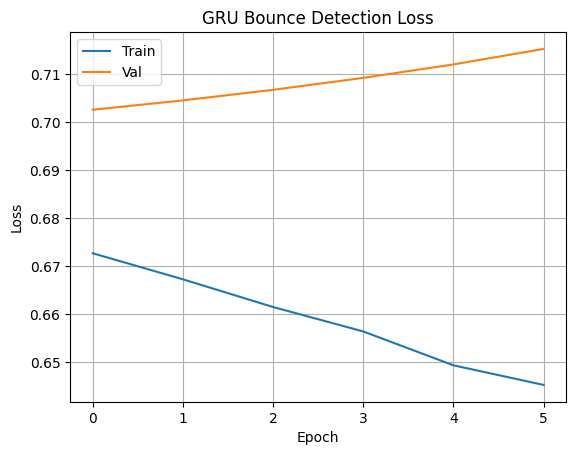

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import os
import matplotlib.pyplot as plt

# === Load Dataset ===
data_dir = "/content/pickleball_ai_data/training/bounce_model"
X = np.load(os.path.join(data_dir, "X.npy"))  # [N, 5, 2]
y = np.load(os.path.join(data_dir, "y.npy"))  # [N]

# === Normalize XY Coordinates ===
X_min = X.min(axis=(0, 1), keepdims=True)
X_max = X.max(axis=(0, 1), keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-6)

# === Convert to Tensors ===
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# === Create Dataset and Split ===
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

# === Define GRU Model ===
class BounceGRU(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=1):
        super(BounceGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, _ = self.gru(x)         # [batch, seq_len, hidden]
        last = out[:, -1, :]         # [batch, hidden]
        return self.fc(last).squeeze()

model = BounceGRU().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Train Model ===
EPOCHS = 30
best_val_loss = float("inf")
patience, wait = 5, 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.cuda(), yb.cuda()
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(data_dir, "bounce_model.pt"))
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# === Plot Training Curve ===
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title("GRU Bounce Detection Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [14]:
import torch
import numpy as np
import pandas as pd
from collections import deque

# === Paths ===
MODEL_PATH = "/content/pickleball_ai_data/training/bounce_model/bounce_model.pt"
DATA_CSV = "/content/ball_positions.csv"
OUTPUT_CSV = "/content/ball_with_bounce_pred.csv"

# === Load model ===
class BounceGRU(torch.nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=1):
        super(BounceGRU, self).__init__()
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :]).squeeze()

model = BounceGRU().cuda()
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# === Load and Normalize Ball Positions ===
df = pd.read_csv(DATA_CSV)
xy = df[['x', 'y']].values
xy_norm = (xy - xy.min(axis=0)) / (xy.max(axis=0) - xy.min(axis=0) + 1e-6)

# === Prepare sequences for prediction ===
window_size = 5
half = window_size // 2
sequences = []
frames = []

for i in range(half, len(xy_norm) - half):
    seq = xy_norm[i-half:i+half+1]
    if seq.shape == (5, 2):
        sequences.append(seq)
        frames.append(df.loc[i, 'frame'])

X = torch.tensor(np.array(sequences), dtype=torch.float32).cuda()

# === Predict bounces ===
with torch.no_grad():
    preds = model(X).cpu().numpy()

# === Threshold and Save ===
df_bounce = df.copy()
df_bounce["pred_bounce"] = False
for i, frame in enumerate(frames):
    if preds[i] > 0.5:
        df_bounce.loc[df_bounce["frame"] == frame, "pred_bounce"] = True

df_bounce.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Saved bounce predictions to: {OUTPUT_CSV}")


✅ Saved bounce predictions to: /content/ball_with_bounce_pred.csv


In [10]:
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon

ANNOTATION_PATH = "/content/pickleball_ai_data/manual_cvat/annotations.xml"

tree = ET.parse(ANNOTATION_PATH)
root = tree.getroot()

# We'll extract only from the first frame
court_polygons = {"right_court": None, "Left_court": None, "kitchen": None}

for image in root.findall("image"):
    for poly in image.findall("polygon"):
        label = poly.attrib["label"]
        if label in court_polygons:
            pts = poly.attrib["points"]
            point_list = [
                tuple(map(float, pt.split(",")))
                for pt in pts.strip().split(";")
            ]
            court_polygons[label] = Polygon(point_list)
    break  # only first frame

print("✅ Court polygons extracted:")
for k, v in court_polygons.items():
    print(f"{k}: {len(v.exterior.coords)} points")


✅ Court polygons extracted:
right_court: 5 points
Left_court: 5 points
kitchen: 7 points


In [15]:
import pandas as pd
from shapely.geometry import Point

# Load predicted bounce data
df = pd.read_csv("/content/ball_with_bounce_pred.csv")

# Filter only bounce frames
bounced_df = df[df["pred_bounce"] == True].copy()

# Use right_court and left_court for checking
right_poly = court_polygons["right_court"]
left_poly = court_polygons["Left_court"]

# Add IN/OUT column
def check_in_out(row):
    point = Point(row['x'], row['y'])
    if right_poly.contains(point) or left_poly.contains(point):
        return "IN"
    return "OUT"

bounced_df["in_out"] = bounced_df.apply(check_in_out, axis=1)

# Merge back into full df
df["in_out"] = "Unknown"
df.loc[bounced_df.index, "in_out"] = bounced_df["in_out"]

# Save
output = "/content/ball_with_bounce_in_out.csv"
df.to_csv(output, index=False)
print(f"✅ Saved in/out results: {output}")


✅ Saved in/out results: /content/ball_with_bounce_in_out.csv


In [13]:
import xml.etree.ElementTree as ET
import pandas as pd

ANNOTATION_PATH = "/content/pickleball_ai_data/manual_cvat/annotations.xml"
OUTPUT_CSV = "/content/ball_positions.csv"

tree = ET.parse(ANNOTATION_PATH)
root = tree.getroot()

positions = []

# Parse each image frame
for image in root.findall("image"):
    frame = int(image.attrib["id"])

    # Loop through boxes in the frame
    for box in image.findall("box"):
        if box.attrib["label"] == "ball":
            xtl = float(box.attrib["xtl"])
            ytl = float(box.attrib["ytl"])
            xbr = float(box.attrib["xbr"])
            ybr = float(box.attrib["ybr"])

            cx = (xtl + xbr) / 2
            cy = (ytl + ybr) / 2

            positions.append({
                "frame": frame,
                "x": round(cx, 2),
                "y": round(cy, 2)
            })

# Save to CSV
df = pd.DataFrame(positions)
df = df.sort_values(by="frame")
df.to_csv(OUTPUT_CSV, index=False)

print(f"✅ Saved {len(df)} ball positions to: {OUTPUT_CSV}")


✅ Saved 361 ball positions to: /content/ball_positions.csv


In [16]:
from ultralytics import YOLO
import cv2
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
import xml.etree.ElementTree as ET
import torch

# === CONFIG ===
VIDEO_PATH = "/content/record.mov"
MODEL_PATH = "/content/best.pt"
GRU_PATH = "/content/pickleball_ai_data/training/bounce_model/bounce_model.pt"
ANNOTATION_PATH = "/content/pickleball_ai_data/manual_cvat/annotations.xml"
OUTPUT_VIDEO = "/content/output_annotated.mp4"
START_FRAME = 29000
END_FRAME = 31000
LABEL_BALL = "ball"

# === Load YOLOv8 model ===
yolo_model = YOLO(MODEL_PATH)

# === Load GRU bounce model ===
class BounceGRU(torch.nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=1):
        super(BounceGRU, self).__init__()
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :]).squeeze()

gru_model = BounceGRU().cuda()
gru_model.load_state_dict(torch.load(GRU_PATH))
gru_model.eval()

# === Extract court polygons from CVAT XML ===
tree = ET.parse(ANNOTATION_PATH)
root = tree.getroot()
court_polygons = {}
for image in root.findall("image"):
    for poly in image.findall("polygon"):
        label = poly.attrib["label"]
        pts = poly.attrib["points"]
        point_list = [tuple(map(float, pt.split(","))) for pt in pts.strip().split(";")]
        court_polygons[label] = Polygon(point_list)
    break  # only first frame

right_poly = court_polygons.get("right_court")
left_poly = court_polygons.get("Left_court")

# === Helper: Predict bounce with GRU ===
def predict_bounce_xy_sequence(buffer):
    if len(buffer) < 5:
        return False
    seq = np.array(buffer[-5:])  # last 5 positions
    seq_norm = (seq - seq.min(axis=0)) / (seq.max(axis=0) - seq.min(axis=0) + 1e-6)
    input_tensor = torch.tensor(seq_norm, dtype=torch.float32).unsqueeze(0).cuda()
    with torch.no_grad():
        prob = gru_model(input_tensor).item()
    return prob > 0.5

# === Open video ===
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(3))
height = int(cap.get(4))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (width, height))

frame_number = 0
ball_buffer = []
results_log = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_number > END_FRAME:
        break

    if frame_number < START_FRAME:
        frame_number += 1
        continue

    result = yolo_model(frame)[0]
    detections = result.boxes.data.cpu().numpy()
    names = result.names

    # === Find ball ===
    ball_coords = None
    for det in detections:
        cls_id = int(det[5])
        label = names[cls_id]
        if label == LABEL_BALL:
            x1, y1, x2, y2 = det[0:4]
            cx = int((x1 + x2) / 2)
            cy = int((y1 + y2) / 2)
            ball_coords = (cx, cy)
            break

    if ball_coords:
        ball_buffer.append(ball_coords)

        # === Bounce Prediction ===
        is_bounce = predict_bounce_xy_sequence(ball_buffer)

        # === In/Out Detection ===
        in_out = "Unknown"
        if is_bounce:
            pt = Point(ball_coords)
            if right_poly.contains(pt) or left_poly.contains(pt):
                in_out = "IN"
            else:
                in_out = "OUT"

        # === Draw info ===
        color = (0, 255, 0) if in_out == "IN" else (0, 0, 255)
        cv2.circle(frame, ball_coords, 10, color, -1)
        if is_bounce:
            cv2.putText(frame, f"Bounce: {in_out}", (ball_coords[0]+10, ball_coords[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        results_log.append({
            "frame": frame_number,
            "x": ball_coords[0],
            "y": ball_coords[1],
            "bounce": is_bounce,
            "in_out": in_out
        })

    out.write(frame)
    frame_number += 1

cap.release()
out.release()

# Save bounce results log
df_log = pd.DataFrame(results_log)
df_log.to_csv("/content/bounce_predictions_log.csv", index=False)
print("✅ Saved annotated video and bounce log.")


Streaming output truncated to the last 5000 lines.
Speed: 6.0ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 12.7ms
Speed: 5.5ms preprocess, 12.7ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 11.8ms
Speed: 5.6ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 11.8ms
Speed: 4.9ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 11.8ms
Speed: 4.9ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inferenc